# Posterior Approximations

This notebook outlines the strategies `frankenz` can use to approximate the photometric posterior and compares how well they do relative to brute-force approaches.

# Setup

In [1]:
from __future__ import print_function, division
import sys
import pickle
import numpy as np
import scipy
import matplotlib
from matplotlib import pyplot as plt
from six.moves import range

# import frankenz code
import frankenz

# plot in-line within the notebook
%matplotlib inline

np.random.seed(2018)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

# Data

Following the [previous notebook](https://github.com/joshspeagle/frankenz/blob/master/demos/2%20-%20Photometric%20Inference.ipynb), we will stick with our mock SDSS data.

In [3]:
survey = pickle.load(open('../data/mock_sdss_cww_bpz.pkl', 'rb'))  # load data
types = survey.data['types']  # type flag
templates = survey.data['templates']  # template ID
redshifts = survey.data['redshifts']  # redshift
mags = survey.data['refmags']  # magnitude (reference)
phot_obs = survey.data['phot_obs']  # observed photometry
phot_err = survey.data['phot_err']  # photometry error
phot_true = survey.data['phot_true']  # true photometry
Nobs = len(types)

# Recap

We are interested in constructing an estimate for the population redshift distribution $N(z|\mathbf{g}) = \sum_g P(z|g)$ and individual redshift distributions $P(z|g)$ for a set of $N_\mathbf{g}$ **observed (unlabeled)** galaxies $g \in \mathbf{g}$ by projecting our results onto a relevant (possibly noisy) basis composed of $N_\mathbf{h}$ **training (labeled)** galaxies $h \in \mathbf{h}$ with $N_{\mathbf{h}}$. This constitutes a **"big data" approximation** which assumes that we can reduce a continuous process to a discrete set of comparisons.

Given a **prior** over our basis $P(h)$, we can then write the **posterior** between $h$ and $g$ using **Bayes Theorem** as

$$ P(h|g) = \frac{\mathcal{L}(g|h)\pi(h)}{\mathcal{Z}_g} 
= \frac{\mathcal{L}(g|h)\pi(h)}{\sum_h \mathcal{L}(g|h) \pi(h)} $$

where $\mathcal{Z}_g$ is the **evidence** (i.e. **marginal likelihood**) of $g$.

Each galaxy has a set of observed **flux densities** $\mathbf{F}$ with PDF $P(\hat{\mathbf{F}}|g)$ observed in a set of $N_{\mathbf{b}}$ **photometric bands** indexed by $b \in \mathbf{b}$. Our likelihood is

$$ \mathcal{L}(g|h) \equiv P(\mathbf{F}_g, \mathbf{F}_h) 
= \int P(\hat{\mathbf{F}}_g | \mathbf{F}) P(\hat{\mathbf{F}}_h | \mathbf{F}) \pi(\mathbf{F}) d\mathbf{F} $$

where $\pi(\mathbf{F})$ is a $N_{\mathbf{b}}$-dimensional prior over the true flux densities.

Given our labeled objects $\mathbf{h}$ with corresponding redshift kernels $K(z|h)$, we get

$$ 
P(z|g) = \sum_h K(z|h)P(h|g) = \frac{\sum_h K(z|h)\mathcal{L}(g|h)\pi(h)}{\sum_h \mathcal{L}(g|h)\pi(h)}
$$

which corresponds to a posterior-weighted mixture of the $K(z|h)$ redshift kernels.

# Implicitly Defining Priors from Samples

As discussed in the previous notebook, writing $P(h)$ is terms of physical parameters characterizing the underlying process can be difficult. However, given a representative collection of labeled data whose distribution over the observables (and the labels) follows the same distribution(s) probed by the observed data, we can use the relative number density of samples to *implicitly* define a prior over the physical parameters of interest and safely set $P(h)=1$.

We re-illustrate this below using a random galaxy sampled from our mock data.

In [4]:
# sample good example object
idx = np.random.choice(np.arange(Nobs)[(mags < 22.5) & (mags > 22)])

In [5]:
# compute loglikelihoods (noiseless) 
ll, nb, chisq = frankenz.pdf.loglike(phot_obs[idx], phot_err[idx],
                                     np.ones(survey.NFILTER),
                                     phot_true, phot_err,
                                     np.ones_like(phot_true),
                                     free_scale=False, ignore_model_err=True,
                                     dim_prior=False)

In [6]:
# compute color loglikelihoods over grid
mphot = survey.models['data'].reshape(-1, survey.NFILTER)
merr = np.zeros_like(mphot)
mmask = np.ones_like(mphot)
llm, nbm, chisqm, sm, smerr = frankenz.pdf.loglike(phot_obs[idx], phot_err[idx], 
                                                   np.ones(survey.NFILTER),
                                                   mphot, merr, mmask,
                                                   dim_prior=False, free_scale=True, 
                                                   ignore_model_err=True, return_scale=True)

In [7]:
# compute prior
mzgrid = survey.models['zgrid']
prior = np.array([frankenz.priors.bpz_pz_tm(mzgrid, t, mags[idx]) 
                  for t in survey.TTYPE]).T.flatten()

In [8]:
# define plotting functions
try:
    from scipy.special import logsumexp
except ImportError:
    from scipy.misc import logsumexp

def plot_flux(phot_obs, phot_err, phot, logl, 
              ocolor='black', mcolor='blue', thresh=1e-1):
    """Plot SEDs."""

    wave = np.array([f['lambda_eff'] for f in survey.filters])
    wt = np.exp(logl)
    wtmax = wt.max()
    sel = np.arange(len(phot))[wt > thresh * wtmax]
    [plt.plot(wave, phot[i], alpha=wt[i]/wtmax*0.4, lw=3, 
              zorder=1, color=mcolor) for i in sel]
    plt.errorbar(wave, phot_obs, yerr=phot_err, lw=3, color=ocolor, zorder=2)
    plt.xlabel(r'Wavelength ($\AA$)')
    plt.xlim([wave.min() - 100, wave.max() + 100])
    plt.ylim([(phot_obs - phot_err).min() * 0.9, (phot_obs + phot_err).max() * 1.1])
    plt.ylabel(r'$F_\nu$')
    plt.yticks(fontsize=24)
    plt.tight_layout()
    
def plot_redshift(redshifts, logl, ztrue=None, color='yellow', 
                  tcolor='red'):
    """Plot redshift PDF."""
    
    n, _, _ = plt.hist(redshifts, bins=zgrid, weights=np.exp(logl), 
                       histtype='stepfilled', edgecolor='black',
                       lw=3, color=color, alpha=0.8)
    if ztrue is not None:
        plt.vlines(ztrue, 0., n.max() * 1.1, color=tcolor, linestyles='--', lw=2)
    plt.xlabel('Redshift')
    plt.ylabel('PDF')
    plt.xlim([zgrid[0], zgrid[-1]])
    plt.ylim([0., n.max() * 1.1])
    plt.yticks([])
    plt.tight_layout()

def plot_zt(redshifts, templates, logl, ztrue=None, ttrue=None,
            cmap='viridis', tcolor='red', thresh=1e-2):
    """Plot joint template-redshift PDF."""
    lsum = logsumexp(logl)
    wt = np.exp(logl - lsum)
    plt.hist2d(redshifts, templates, bins=[zgrid, tgrid],
               weights=wt, 
               cmin=thresh*max(wt),
               cmap=cmap)
    if ttrue is not None:
        plt.hlines(ttrue, zgrid.min(), zgrid.max(), 
                   color=tcolor, lw=2, linestyles='--')
    if ztrue is not None:
        plt.vlines(ztrue, tgrid.min(), tgrid.max(), 
                   color=tcolor, lw=2, linestyles='--')
    plt.xlabel('Redshift')
    plt.ylabel('Template')
    plt.xlim([zgrid[0], zgrid[-1]])
    plt.ylim([tgrid[0], tgrid[-1]])
    plt.tight_layout()

/home/joshspeagle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log
/home/joshspeagle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in log
/home/joshspeagle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in log


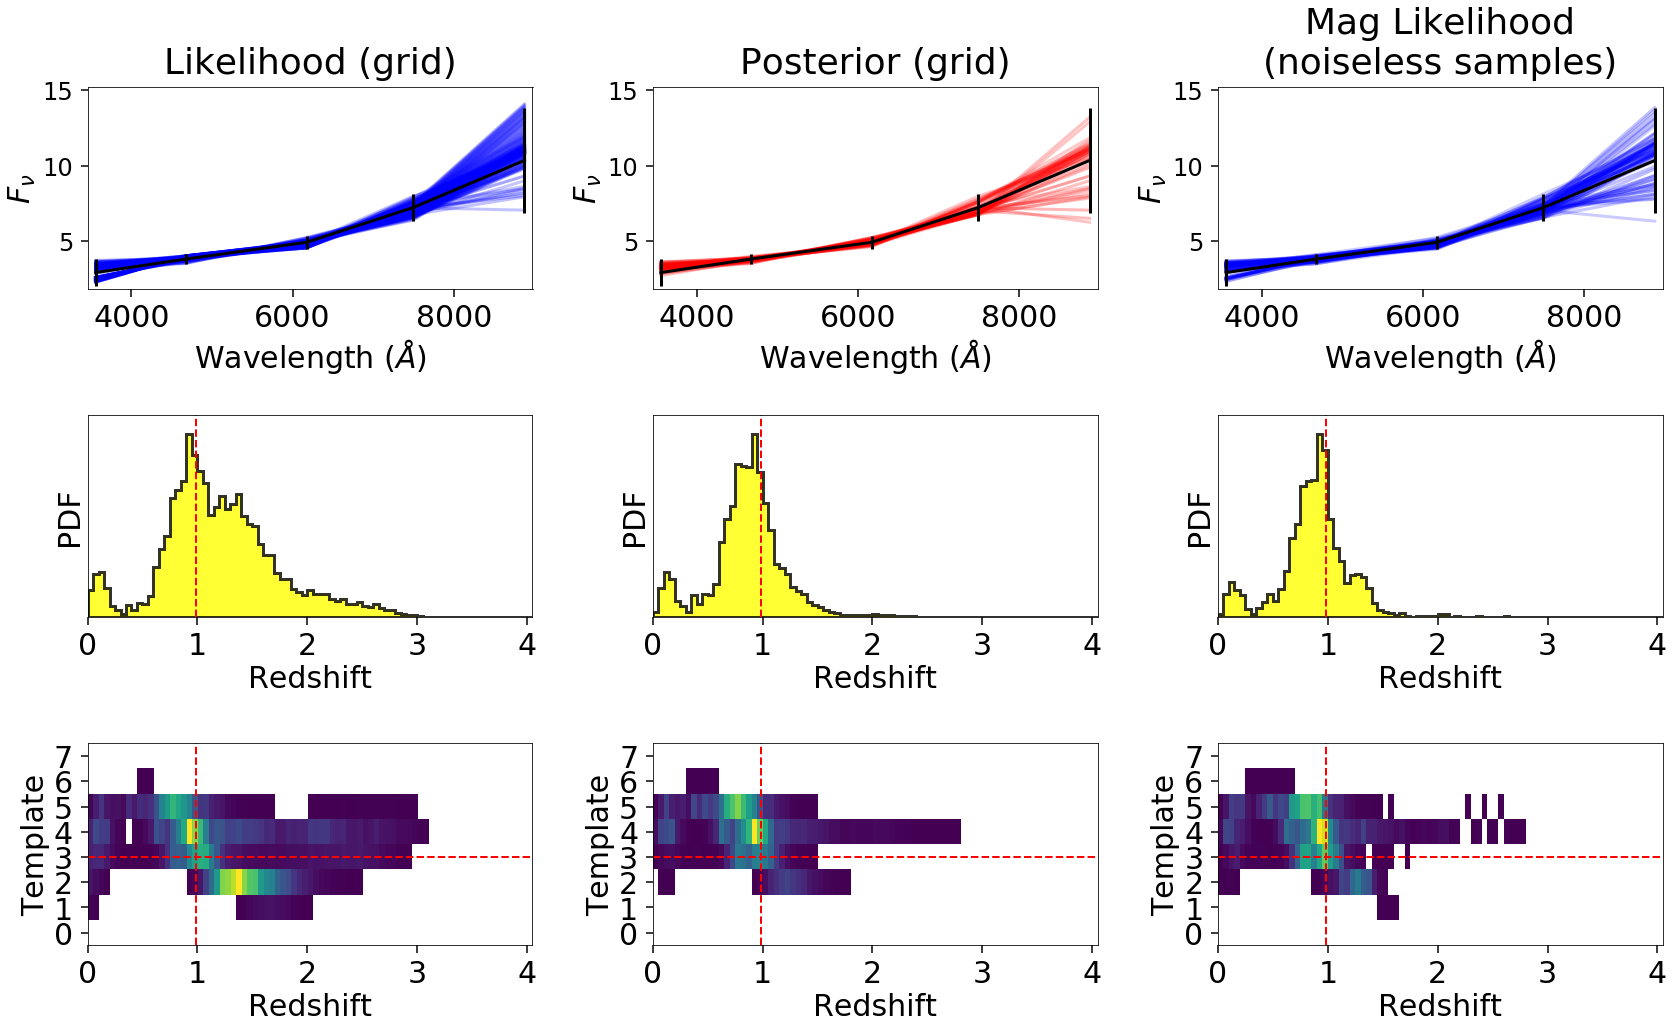

In [9]:
zgrid = np.arange(0., 4. + 0.1, 0.05)
tgrid = np.arange(survey.NTEMPLATE + 1) - 0.5

# plot flux distribution
plt.figure(figsize=(24, 15))
plt.subplot(3,3,1)
plot_flux(phot_obs[idx], phot_err[idx], sm[:, None] * mphot,
          llm, ocolor='black', mcolor='blue', thresh=0.5)
plt.title('Likelihood (grid)', y=1.04)
plt.subplot(3,3,2)
plot_flux(phot_obs[idx], phot_err[idx], sm[:, None] * mphot,
          llm + np.log(prior).flatten(), 
          ocolor='black', mcolor='red', thresh=0.5)
plt.title('Posterior (grid)', y=1.04)
plt.subplot(3,3,3)
plot_flux(phot_obs[idx], phot_err[idx], phot_true, ll, 
          ocolor='black', mcolor='blue', thresh=0.5)
plt.title('Mag Likelihood\n(noiseless samples)', y=1.04)

# plot redshift distribution
mredshifts = np.array([mzgrid for i in range(survey.NTEMPLATE)]).T.flatten()
plt.subplot(3,3,4)
plot_redshift(mredshifts, llm, ztrue=redshifts[idx])
plt.xticks(zgrid[::20])
plt.subplot(3,3,5)
plot_redshift(mredshifts, llm + np.log(prior).flatten(),
              ztrue=redshifts[idx])
plt.xticks(zgrid[::20])
plt.subplot(3,3,6)
plot_redshift(redshifts, ll, ztrue=redshifts[idx])
plt.xticks(zgrid[::20])

# plot redshift-type joint distribution
mtemplates = np.array([np.arange(survey.NTEMPLATE) 
                       for i in range(len(mzgrid))]).flatten()
plt.subplot(3,3,7)
plot_zt(mredshifts, mtemplates, llm, thresh=1e-2,
        ztrue=redshifts[idx], ttrue=templates[idx])
plt.xticks(zgrid[::20])
plt.yticks(tgrid[1:] - 0.5)
plt.subplot(3,3,8)
plot_zt(mredshifts, mtemplates, llm + np.log(prior).flatten(),
        thresh=1e-2, ztrue=redshifts[idx], ttrue=templates[idx])
plt.xticks(zgrid[::20])
plt.yticks(tgrid[1:] - 0.5)
plt.subplot(3,3,9)
plot_zt(redshifts, templates, ll,
        ztrue=redshifts[idx], ttrue=templates[idx])
plt.xticks(zgrid[::20])
plt.yticks(tgrid[1:] - 0.5);

Again, in practice we do not often have access to a fully representative training sample. We will return to methods to derive $P(h)$ later.

# Dealing with Large Datasets

For most applications, we often will be dealing with a large sample of objects. We'll define a particular sample below following the [previous notebook](https://github.com/joshspeagle/frankenz/blob/master/demos/2%20-%20Photometric%20Inference.ipynb).

In [10]:
# training/testing set divide
sel = (phot_obs / phot_err)[:, survey.ref_filter] > 5.  # S/N > 5 cut
Nsel = sel.sum()

Ntrain, Ntest = 60000, 5000
train_sel = np.arange(Nobs)[sel][:Ntrain]  # training set
test_sel = np.arange(Nobs)[sel][Ntrain:Ntrain+Ntest]  # testing set
Nmodel = len(mphot)

print('Number of observed galaxies (all):', Nobs)
print('Number of observed galaxies (selected):', Nsel)
print('Number of models:', Nmodel)
print('Number of training galaxies:', Ntrain)
print('Number of testing galaxies:', Ntest)

Number of observed galaxies (all): 200000
Number of observed galaxies (selected): 67951
Number of models: 8000
Number of training galaxies: 60000
Number of testing galaxies: 5000


In [11]:
# initialize datasets
phot_train, phot_test = phot_obs[train_sel], phot_obs[test_sel]
err_train, err_test = phot_err[train_sel], phot_err[test_sel]
mask_train, mask_test = np.ones_like(phot_train), np.ones_like(phot_test)

In [12]:
# initialize asinh magnitudes ("Luptitudes")
flux_zeropoint = 10**(-0.4 * -23.9) # AB magnitude zeropoint
fdepths = np.array([f['depth_flux1sig'] for f in survey.filters])
mag, magerr = frankenz.pdf.luptitude(phot_obs, phot_err, skynoise=fdepths,
                                     zeropoints=flux_zeropoint)

# initialize magnitude dictionary 
mdict = frankenz.pdf.PDFDict(pdf_grid=np.arange(-20., 60., 5e-3), 
                             sigma_grid=np.linspace(0.01, 5., 500))

# initialize redshift dictionary
rdict = frankenz.pdf.PDFDict(pdf_grid=np.arange(0., 7.+1e-5, 0.01), 
                             sigma_grid=np.linspace(0.005, 2., 500))

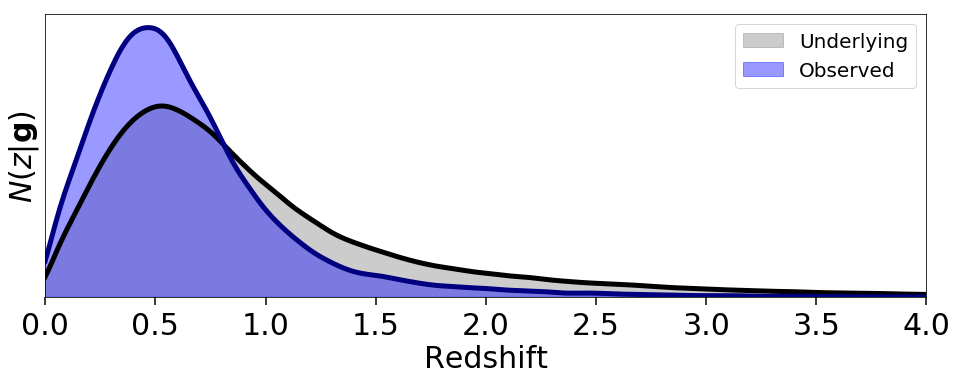

In [13]:
# plotting redshift distribution
plt.figure(figsize=(14, 6))
rsmooth = 0.05

# all
zerr_t = np.ones_like(redshifts) * rsmooth
z_pdf = frankenz.pdf.gauss_kde_dict(rdict, y=redshifts,
                                    y_std=zerr_t)
plt.plot(rdict.grid, z_pdf / z_pdf.sum(), lw=5, color='black')
plt.fill_between(rdict.grid, z_pdf / z_pdf.sum(), color='gray',
                 alpha=0.4, label='Underlying')

# selected
zsel_pdf = frankenz.pdf.gauss_kde_dict(rdict, y=redshifts[sel],
                                       y_std=zerr_t[sel])
plt.plot(rdict.grid, zsel_pdf / zsel_pdf.sum(), lw=5, color='navy')
plt.fill_between(rdict.grid, zsel_pdf / zsel_pdf.sum(), 
                 color='blue', alpha=0.4, label='Observed')

# prettify
plt.xlim([0, 4])
plt.ylim([0, None])
plt.yticks([])
plt.legend(fontsize=20)
plt.xlabel('Redshift')
plt.ylabel('$N(z|\mathbf{g})$')
plt.tight_layout()

# Method 1: Brute Force (`BruteForce`)

The simplest approach is the brute force approach where we attempt to fit *all* our models to the data. Brute force approaches can often be surprising fast because they can exploit quick matrix operations over large arrays. However, all brute force approaches scale as $\mathcal{O}(N_\mathbf{h})$ both in time and in memory usage and so quickly become infeasible when dealing with large training datasets/model grids.

We'll initialize two solvers: one based on fitting the entire training set (60k objects) in magnitude space and another based on fitting our underlying model grid (8k objects) in color space.

In [14]:
from frankenz.fitting import BruteForce

# initialize objects
model_BF = BruteForce(mphot, merr, mmask)  # model grid
train_BF = BruteForce(phot_train, err_train, mask_train)  # training data

In [15]:
# define bpz log(prob) function
def lprob_bpz(x, xe, xm, ys, yes, yms, 
              mzgrid=None, ttypes=None, ref=None):
    results = frankenz.pdf.loglike(x, xe, xm, ys, yes, yms,
                                   ignore_model_err=True,
                                   dim_prior=False,
                                   free_scale=True)
    lnlike, ndim, chi2 = results
    mag = -2.5 * np.log10(x[ref]) + 23.9
    prior = np.array([frankenz.priors.bpz_pz_tm(mzgrid, t, mag)
                      for t in ttypes]).T.flatten()
    lnprior = np.log(prior)
    return lnprior, lnlike, lnlike + lnprior, ndim, chi2

# define sample mag log(prob) function
def lprob_train(x, xe, xm, ys, yes, yms):
    results = frankenz.pdf.loglike(x, xe, xm, ys, yes, yms,
                                   dim_prior=False)
    lnlike, ndim, chi2 = results
    return np.zeros_like(lnlike), lnlike, lnlike, ndim, chi2

In [16]:
rsmooth = 0.01

# fit data
model_BF.fit(phot_test, err_test, mask_test, lprob_bpz, 
             lprob_args=[mzgrid, survey.TTYPE, survey.ref_filter])

# compute posterior-weighted redshift PDFs
mredshifts = np.array([mzgrid for i in range(survey.NTEMPLATE)]).T.flatten()
pdfs_post, gofs = model_BF.predict(mredshifts, np.ones_like(mredshifts) * rsmooth,
                                   label_dict=rdict, return_gof=True)
lmap_post, levid_post = gofs

/home/joshspeagle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log
Fitting object 5000/5000
Generating PDF 5000/5000


In [17]:
# compute likelihood-weighted redshift PDFs
pdfs_like, gofs = model_BF.predict(mredshifts, np.ones_like(mredshifts) * rsmooth,
                                   label_dict=rdict, return_gof=True, logwt=model_BF.fit_lnlike)
lmap_like, levid_like = gofs

Generating PDF 5000/5000


Now we'll generate predictions using our training (labeled) data.

In [18]:
# compute PDFs from training set using brute force
pdfs_bf, gofs = train_BF.fit_predict(phot_test, err_test, mask_test,
                                     redshifts[train_sel], 
                                     np.ones_like(train_sel) * rsmooth,
                                     lprob_func=lprob_train,
                                     label_dict=rdict, save_fits=False,
                                     return_gof=True)
lmap_bf, levid_bf = gofs

Generating PDF 5000/5000


/home/joshspeagle/anaconda/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


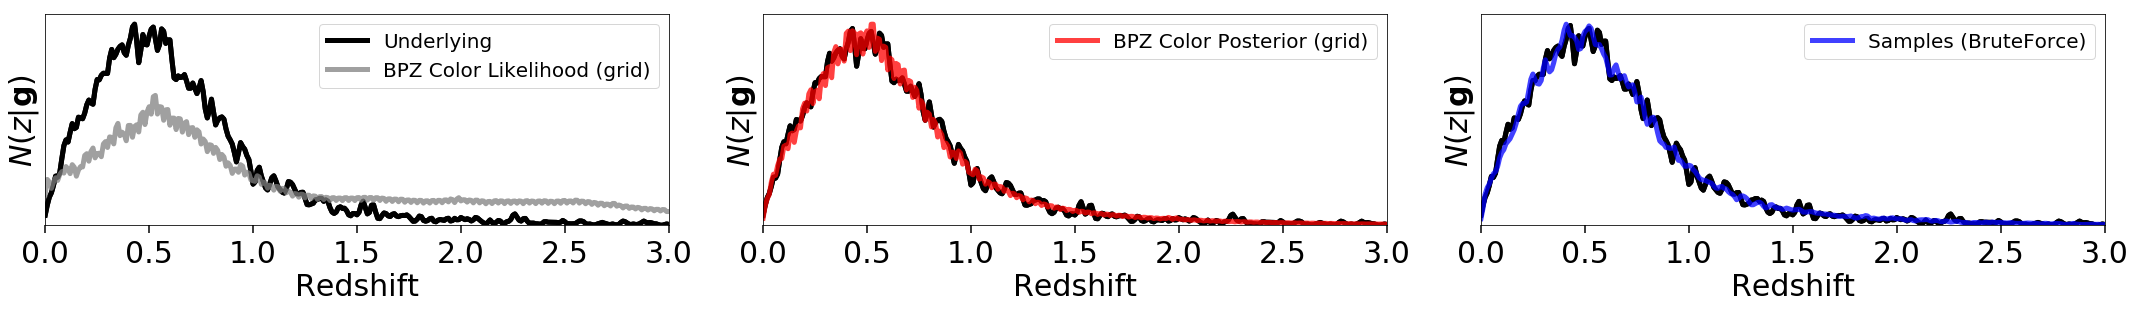

In [19]:
# true distribution
zpdf0 = frankenz.pdf.gauss_kde_dict(rdict, y=redshifts[test_sel],
                                    y_std=np.ones_like(test_sel) * rsmooth)

# plotting
plt.figure(figsize=(40, 5))
plt.subplot(1, 4, 1)
plt.plot(rdict.grid, zpdf0, lw=5, color='black',
         label='Underlying')
plt.plot(rdict.grid, pdfs_like.sum(axis=0), 
         lw=5, color='gray', alpha=0.75, 
         label='BPZ Color Likelihood (grid)')
for i in range(1, 3):
    plt.subplot(1, 4, i+1)
    plt.plot(rdict.grid, zpdf0, lw=5, color='black')
plt.subplot(1, 4, 2)
plt.plot(rdict.grid, pdfs_post.sum(axis=0), 
         lw=5, color='red', alpha=0.75,
         label='BPZ Color Posterior (grid)')
plt.subplot(1, 4, 3)
plt.plot(rdict.grid, pdfs_bf.sum(axis=0), 
         lw=5, color='blue', alpha=0.75,
         label='Samples (BruteForce)')
for i in range(3):
    plt.subplot(1, 4, i+1)
    plt.plot(rdict.grid, zpdf0, lw=5, color='black', zorder=-1)
    plt.xlim([0., 3.])
    plt.ylim([0., None])
    plt.yticks([])
    plt.legend(fontsize=20)
    plt.xlabel('Redshift')
    plt.ylabel('$N(z|\mathbf{g})$')
    plt.tight_layout()

As before, the population redshift distribution $N(z|\mathbf{g})$ computed from our noisy flux densities is very close to that computed by the (approximate) BPZ posterior. Let's also take a look at the 2-D redshift distributions along with the quality of the PDFs.

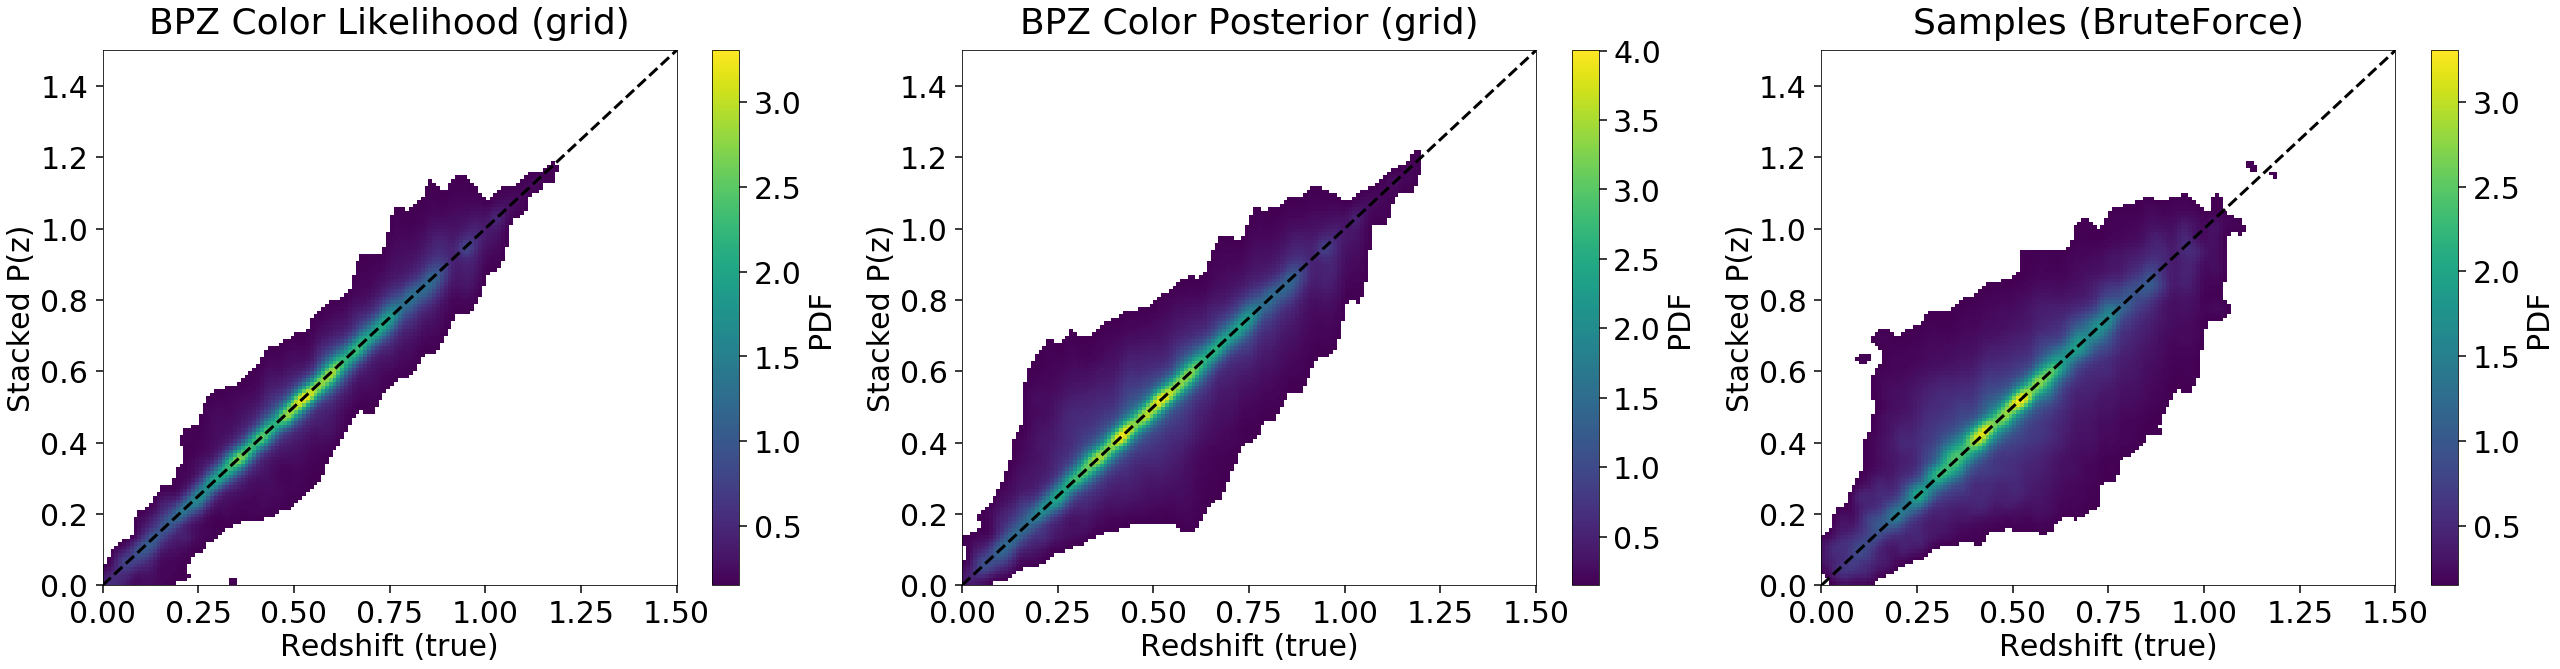

In [20]:
from frankenz import plotting as fzplot

# plot stacked PDFs
plt.figure(figsize=(48, 10))
plt.subplot(1, 4, 1)
hh = fzplot.truth_vs_pdf(redshifts[test_sel], np.zeros_like(test_sel), 
                         pdfs_like, rdict, plot_thresh=0.15, smooth=1.5)
plt.title('BPZ Color Likelihood (grid)', y=1.02)
plt.subplot(1, 4, 2)
hh = fzplot.truth_vs_pdf(redshifts[test_sel], np.zeros_like(test_sel), 
                         pdfs_post, rdict, plot_thresh=0.15, smooth=1.5)
plt.title('BPZ Color Posterior (grid)', y=1.02)
plt.subplot(1, 4, 3)
hh = fzplot.truth_vs_pdf(redshifts[test_sel], np.zeros_like(test_sel), 
                         pdfs_bf, rdict, plot_thresh=0.15, smooth=1.5)
plt.title('Samples (BruteForce)', y=1.02)
for i in range(3):
    plt.subplot(1, 4, i+1)
    plt.xlabel('Redshift (true)')
    plt.ylabel('Stacked P(z)')
    plt.xlim([0., 1.5])
    plt.ylim([0., 1.5])
    plt.tight_layout()

In [21]:
def cdf_plot(pdfs, levid, lmap):
    csel = ((levid > np.sort(levid)[int(0.05 * Ntest)]) &
            (lmap > np.sort(lmap)[int(0.05 * Ntest)])) # remove bad fits
    fzplot.cdf_vs_ecdf(redshifts[test_sel], np.zeros_like(test_sel),
                       pdfs, rdict.grid, 
                       plot_kwargs={'color': 'blue', 'alpha': 0.8, 'lw': 3})
    fzplot.cdf_vs_ecdf(redshifts[test_sel], np.zeros_like(test_sel),
                       pdfs, rdict.grid, weights=csel,
                       plot_kwargs={'color': 'red', 'alpha': 0.8, 'lw': 3})
    plt.plot([0, 1], [0, 1], lw=3, color='black', ls='--')

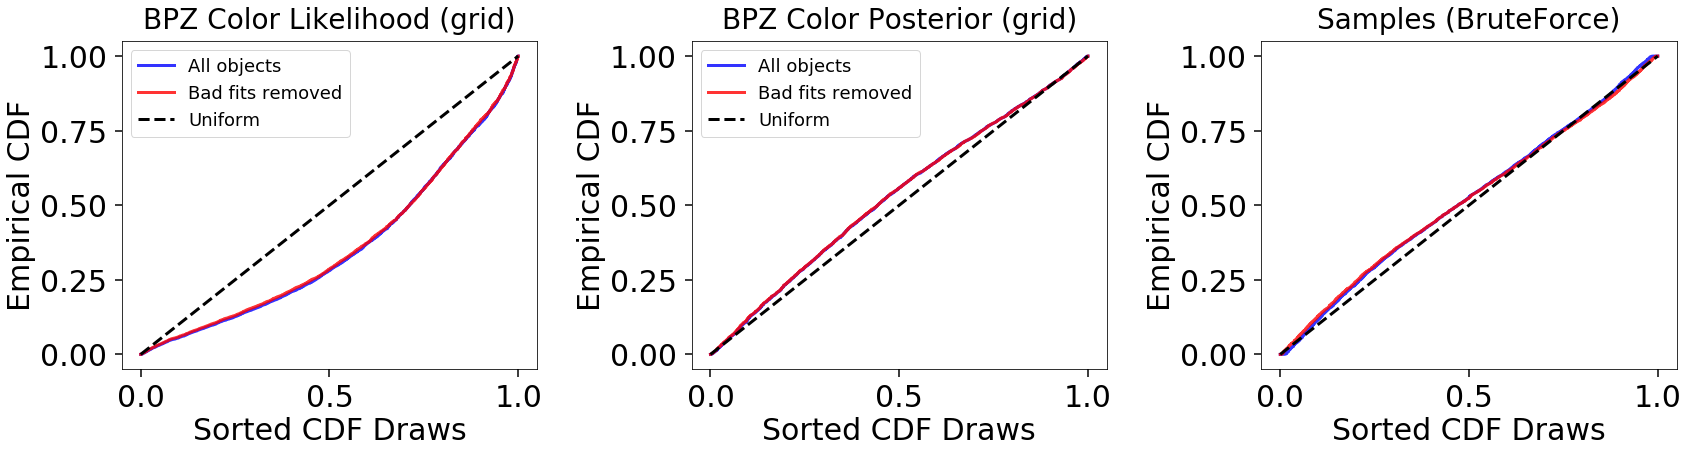

In [22]:
# plot CDF tests
plt.figure(figsize=(32, 7))
plt.subplot(1, 4, 1)
cdf_plot(pdfs_like, levid_like, lmap_like)
plt.legend(['All objects', 'Bad fits removed', 'Uniform'], loc='best', fontsize=18)
plt.title('BPZ Color Likelihood (grid)', fontsize=28, y=1.02)
plt.tight_layout()
plt.subplot(1, 4, 2)
cdf_plot(pdfs_post, levid_post, lmap_post)
plt.legend(['All objects', 'Bad fits removed', 'Uniform'], loc='best', fontsize=18)
plt.title('BPZ Color Posterior (grid)', fontsize=28, y=1.02)
plt.tight_layout()
plt.subplot(1, 4, 3)
cdf_plot(pdfs_bf, levid_bf, lmap_bf)
plt.title('Samples (BruteForce)', fontsize=28, y=1.02)
plt.tight_layout()

# Method 2: Nearest Neighbors (`NearestNeighbors`)

We've now demonstrated that:
1. The original BPZ posterior is an unbiased probe of the underlying distribution (as expected, since we constructed our mock data from the same priors).
2. Our magnitude-based likelihoods computed over unbiased training data provides is an unbiased (but noisier) probe of the underlying distribution (as expected).

We now turn to the computational challenge of exploiting this training data. In particular, taking a brute-force approach (as we did above) is prohibitively slow. It also penalizes you harshly for expanding your training sample, which seems counter-productive.

To solve this issue (somewhat foreshadowed in our KDE discussion above), we turn to "machine learning". Specifically, we want to use machine learning to give us a **sparse approximation of the true likelihood distribution using a small but unbiased set of neighbors**. In other words, we want to select a small subset of objects ($N_{\mathrm{neighbor}} \ll N_{\mathrm{train}}$) and use the likelihoods evaluated over only those objects as an approximation of the overall likelihood.

Unfortunately, finding a subset of nearest neighbors in likelihood-space is not straightforward since the likelihood depends on the pairwise combined errors of any two objects $g$ and $h$. One way that `frankenz` tries to get around this problem is by supplementing $k$ nearest-neighbor searches using **Monte Carlo methods**: by re-doing our $k$ nearest-neighbor search over $K$ Monte Carlo realizations of $\mathbf{g}$ and $\mathbf{h}$ and taking the union of all neighbors, we can generate a *consistent* estimate of the set of "true" nearest neighbors. We refer to this as **KMCkNN** for short.

In [23]:
from frankenz.fitting import NearestNeighbors

flux_zeropoint = 10**(-0.4 * -23.9) # AB magnitude zeropoint
fdepths = np.array([f['depth_flux1sig'] for f in survey.filters])  # 5-sigma depths

# initialize NN object
train_NN = NearestNeighbors(phot_train, err_train, mask_train,
                            feature_map='luptitude',
                            fmap_args=[fdepths, flux_zeropoint])

25/25 KDTrees constructed


In [24]:
# fit and generate PDFs
pdfs_nn, gofs = train_NN.fit_predict(phot_test, err_test, mask_test,
                                     redshifts[train_sel], 
                                     np.ones_like(train_sel) * rsmooth,
                                     lprob_func=lprob_train,
                                     label_dict=rdict, return_gof=True)
lmap_nn, levid_nn = gofs

Generating PDF 5000/5000


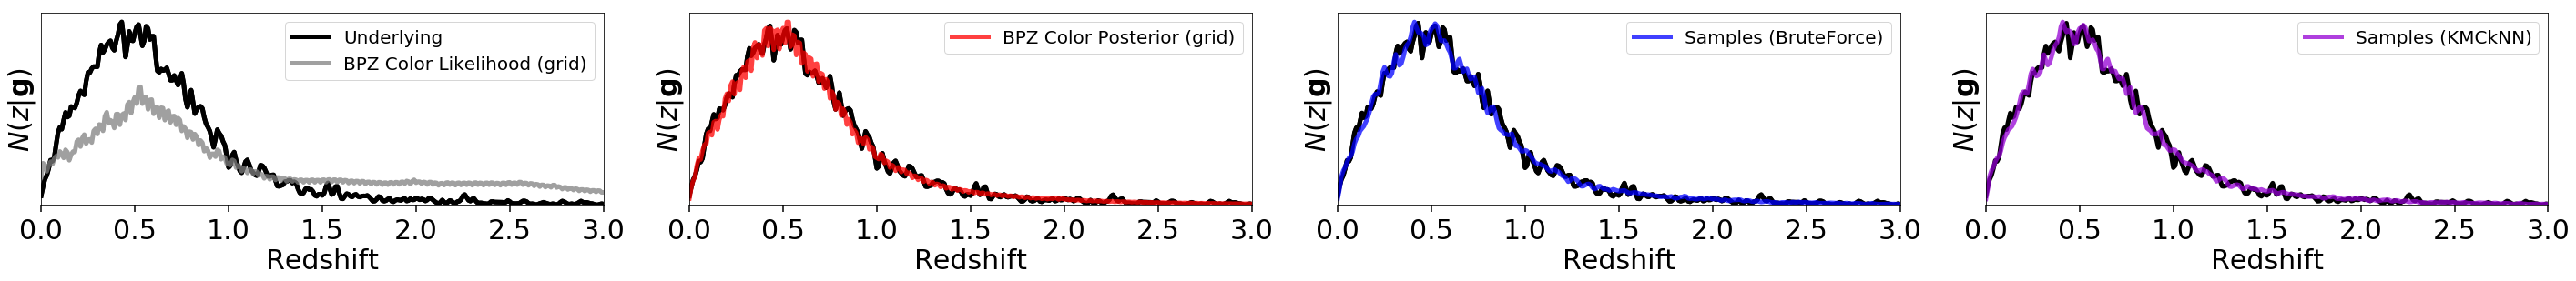

In [25]:
# plotting
plt.figure(figsize=(40, 5))
plt.subplot(1, 4, 1)
plt.plot(rdict.grid, zpdf0, lw=5, color='black',
         label='Underlying')
plt.plot(rdict.grid, pdfs_like.sum(axis=0), 
         lw=5, color='gray', alpha=0.75, 
         label='BPZ Color Likelihood (grid)')
for i in range(1, 3):
    plt.subplot(1, 4, i+1)
    plt.plot(rdict.grid, zpdf0, lw=5, color='black')
plt.subplot(1, 4, 2)
plt.plot(rdict.grid, pdfs_post.sum(axis=0), 
         lw=5, color='red', alpha=0.75,
         label='BPZ Color Posterior (grid)')
plt.subplot(1, 4, 3)
plt.plot(rdict.grid, pdfs_bf.sum(axis=0), 
         lw=5, color='blue', alpha=0.75,
         label='Samples (BruteForce)')
plt.subplot(1, 4, 4)
plt.plot(rdict.grid, pdfs_nn.sum(axis=0), 
         lw=5, color='darkviolet', alpha=0.75,
         label='Samples (KMCkNN)')
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.plot(rdict.grid, zpdf0, lw=5, color='black', zorder=-1)
    plt.xlim([0., 3.])
    plt.ylim([0., None])
    plt.yticks([])
    plt.legend(fontsize=20)
    plt.xlabel('Redshift')
    plt.ylabel('$N(z|\mathbf{g})$')
    plt.tight_layout()

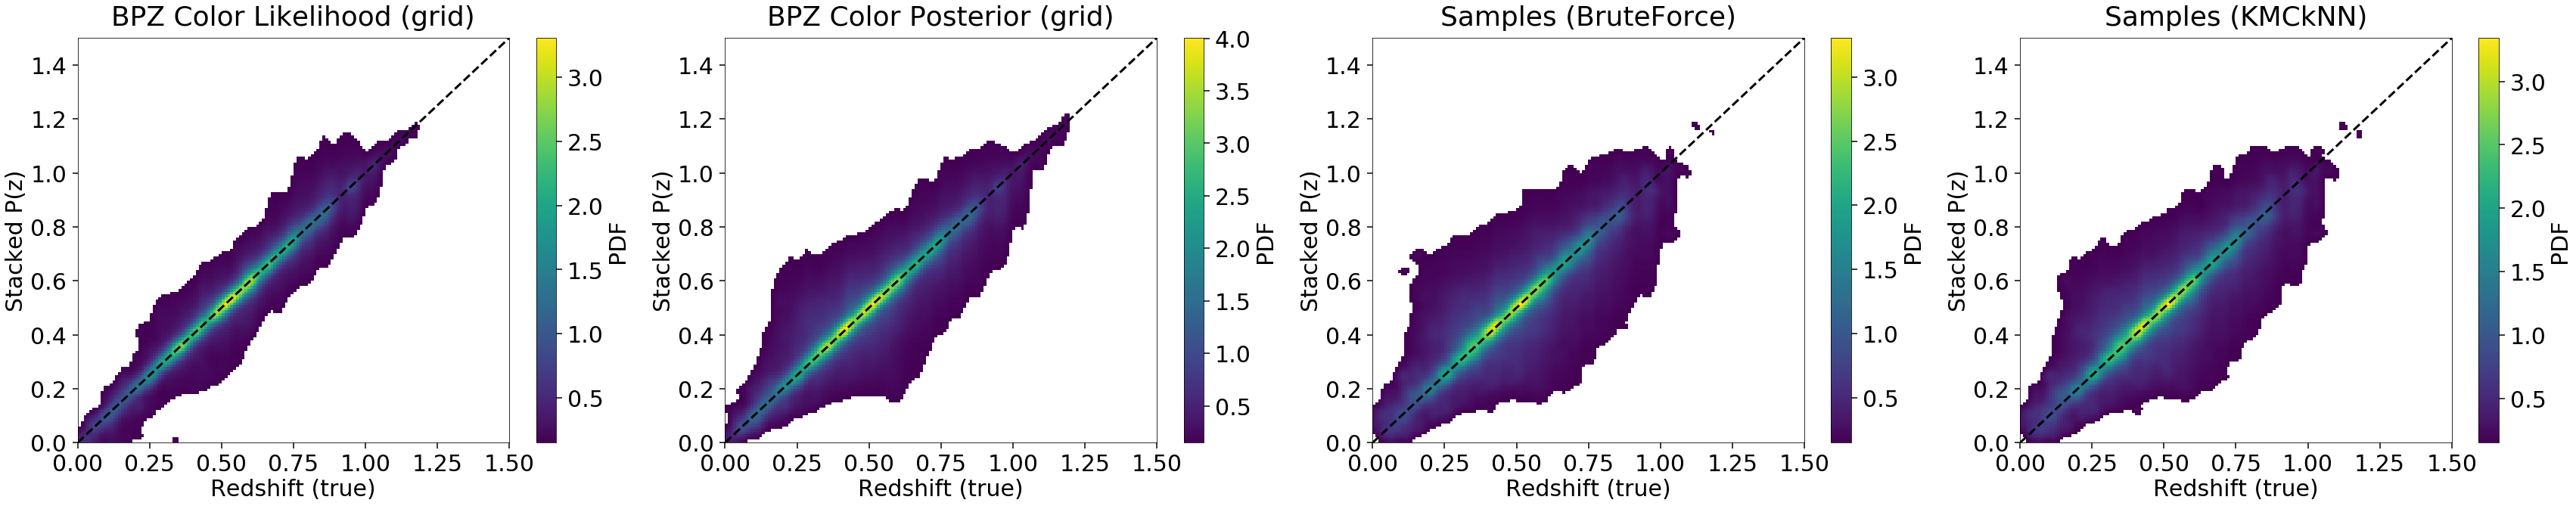

In [26]:
# plot stacked PDFs
plt.figure(figsize=(48, 10))
plt.subplot(1, 4, 1)
hh = fzplot.truth_vs_pdf(redshifts[test_sel], np.zeros_like(test_sel), 
                         pdfs_like, rdict, plot_thresh=0.15, smooth=1.5)
plt.title('BPZ Color Likelihood (grid)', y=1.02)
plt.subplot(1, 4, 2)
hh = fzplot.truth_vs_pdf(redshifts[test_sel], np.zeros_like(test_sel), 
                         pdfs_post, rdict, plot_thresh=0.15, smooth=1.5)
plt.title('BPZ Color Posterior (grid)', y=1.02)
plt.subplot(1, 4, 3)
hh = fzplot.truth_vs_pdf(redshifts[test_sel], np.zeros_like(test_sel), 
                         pdfs_bf, rdict, plot_thresh=0.15, smooth=1.5)
plt.title('Samples (BruteForce)', y=1.02)
plt.subplot(1, 4, 4)
hh = fzplot.truth_vs_pdf(redshifts[test_sel], np.zeros_like(test_sel), 
                         pdfs_nn, rdict, plot_thresh=0.15, smooth=1.5)
plt.title('Samples (KMCkNN)', y=1.02)
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.xlabel('Redshift (true)')
    plt.ylabel('Stacked P(z)')
    plt.xlim([0., 1.5])
    plt.ylim([0., 1.5])
    plt.tight_layout()

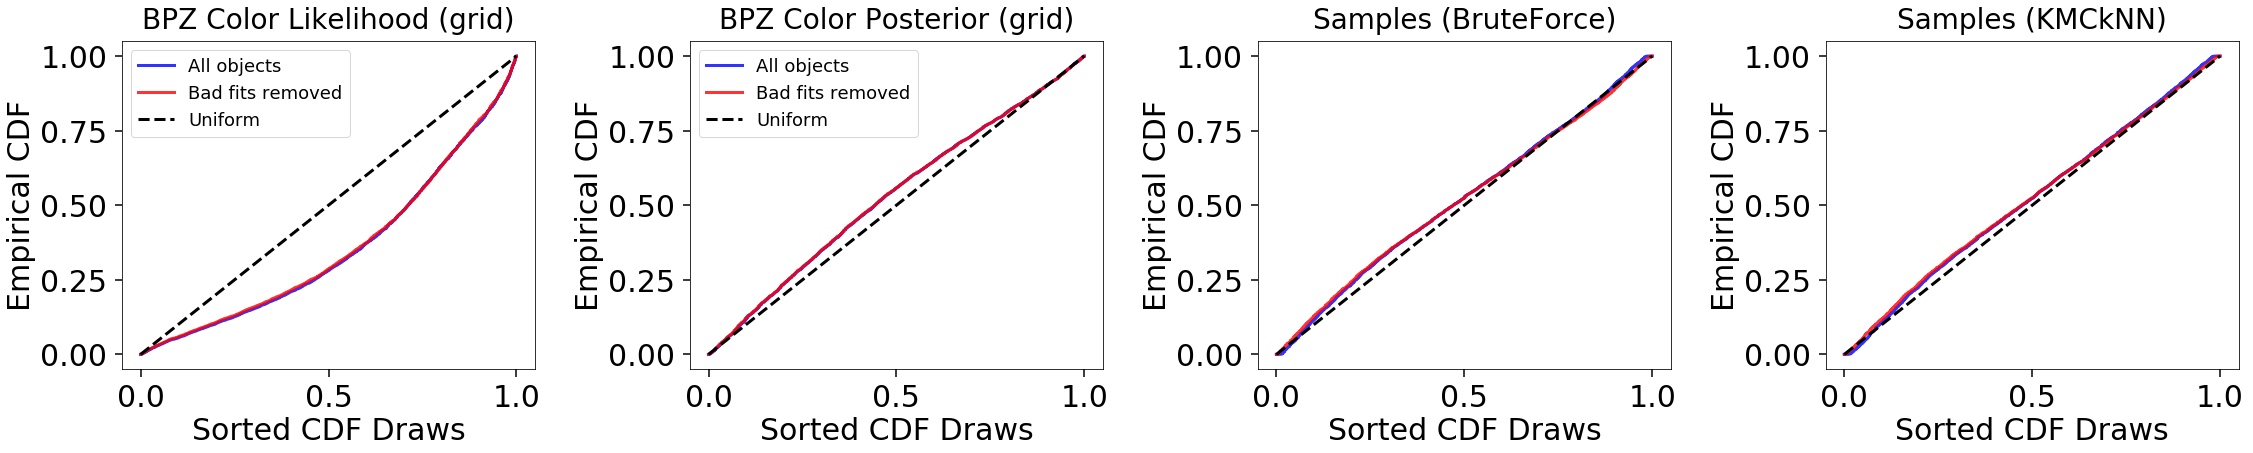

In [27]:
# plot CDF tests
plt.figure(figsize=(32, 7))
plt.subplot(1, 4, 1)
cdf_plot(pdfs_like, levid_like, lmap_like)
plt.legend(['All objects', 'Bad fits removed', 'Uniform'], loc='best', fontsize=18)
plt.title('BPZ Color Likelihood (grid)', fontsize=28, y=1.02)
plt.tight_layout()
plt.subplot(1, 4, 2)
cdf_plot(pdfs_post, levid_post, lmap_post)
plt.legend(['All objects', 'Bad fits removed', 'Uniform'], loc='best', fontsize=18)
plt.title('BPZ Color Posterior (grid)', fontsize=28, y=1.02)
plt.tight_layout()
plt.subplot(1, 4, 3)
cdf_plot(pdfs_bf, levid_bf, lmap_bf)
plt.title('Samples (BruteForce)', fontsize=28, y=1.02)
plt.tight_layout()
plt.subplot(1, 4, 4)
cdf_plot(pdfs_nn, levid_nn, lmap_nn)
plt.title('Samples (KMCkNN)', fontsize=28, y=1.02)
plt.tight_layout()

Our results look pretty decent, so that's reassuring.

# Method 3: Self-Organizing Maps (`SelfOrganizingMap`)

One issue with the KMCkNN method outlined above is that the maximum number of neighbors is limited to $K \times k$ for any particular object. This is not a problem for objects at high/moderate signal-to-noise, where the number of relevant neighbors is often not that large. This does lead to a problem for lower-S/N data, since their larger errors mean that they are consistent with larger portions of the training data. Ideally, we'd be able to select all objects within the relevant $X$-$\sigma$ error bounds so that the number of neighbors scales with the S/N.

`frankenz` tries to accomplish this by trying to find an optimal set of $M_{\mathbf{h}} \ll N_{\mathbf{h}}$ **"effective SEDs"** (Spectral Energy Distributions) that can mimic the distribution of observables in $\mathbf{h}$. These then form a **network** (comprised of SED **nodes**) across the set of observables. Once this network has been constructed, each model in $\mathbf{h}$ is then mapped back onto the network, so that a particular node (effective SED) becomes associated with a set of closely-matching objects in $\mathbf{h}$.

One approach to constructing such a network is a **Self-Organizing Map (SOM)**, which aims to construct a network that is "topologically smooth" in some reduced $M_{\mathbf{b}} < N_{\mathbf{b}}$ dimensional space. This has the added benefit of providing a $M_{\mathbf{b}}$-dimensional projection of the $N_{\mathbf{b}}$-dimensional data, albeit at that cost of assuming "smoothness" in higher-dimensional SED space.

While the geometry of the SOM is flexible in theory, `frankenz` currently only allows for a hyper-cube-style geometries with fixed side lengths (default: 50x50).

In [28]:
from frankenz.fitting import SelfOrganizingMap

train_SOM = SelfOrganizingMap(phot_train, err_train, mask_train)
train_SOM.train_network(err_kernel=0.02*phot_train)
train_SOM.populate_network()

Iteration 2000/2000 [learn= 0.100, sigma= 1.000]     
Mapping objects 100%


Note that while we've just used the defaults here for illustrative purposes, it is actually quite difficult to ensure "good" behavior when training networks directly on photometric flux densities due to the logarithmic number densities and scalings involved. It is much more "natural" to train networks on **"colors"** (i.e. flux density ratios), which tries to optimize out these scale differences.

In [29]:
pdfs_som, gofs = train_SOM.fit_predict(phot_test, err_test, mask_test,
                                       redshifts[train_sel], 
                                       np.ones_like(train_sel) * rsmooth,
                                       lprob_func=lprob_train,
                                       label_dict=rdict, return_gof=True)
lmap_som, levid_som = gofs

Generating PDF 5000/5000


The "two-level" scheme above, where we (1) fit the nodes of the SOM to each object and then (2) fit the models associated with each node, essentially tries to use the SOM as a way to accelerate our search over the set of models $\mathbf{h}$. However, we can also use it to approximate the PDF by using a "one-level" scheme where we just fit the SOM nodes $\mathbf{i}$ and the associated models $\lbrace \mathbf{F}_i \rbrace$ and then stacked the PDFs for the models associated with each node, i.e.

$$ P(z|g) \approx \sum_i P(z|i) P(i|g) = \sum_i \sum_h P(z|h) P(i|h) P(i|g) $$

We can access this approximation in `frankenz` by using the `nodes_only=True` flag when computing fits.

In [30]:
pdfs_som_approx, gofs = train_SOM.fit_predict(phot_test, err_test, mask_test,
                                              redshifts[train_sel], 
                                              np.ones_like(train_sel) * rsmooth,
                                              nodes_only=True,
                                              lprob_func=lprob_train,
                                              label_dict=rdict, return_gof=True)
lmap_som_approx, levid_som_approx = gofs

Generating node PDF 2500/2500
Generating PDF 5000/5000


Let's see how both our approximations do.

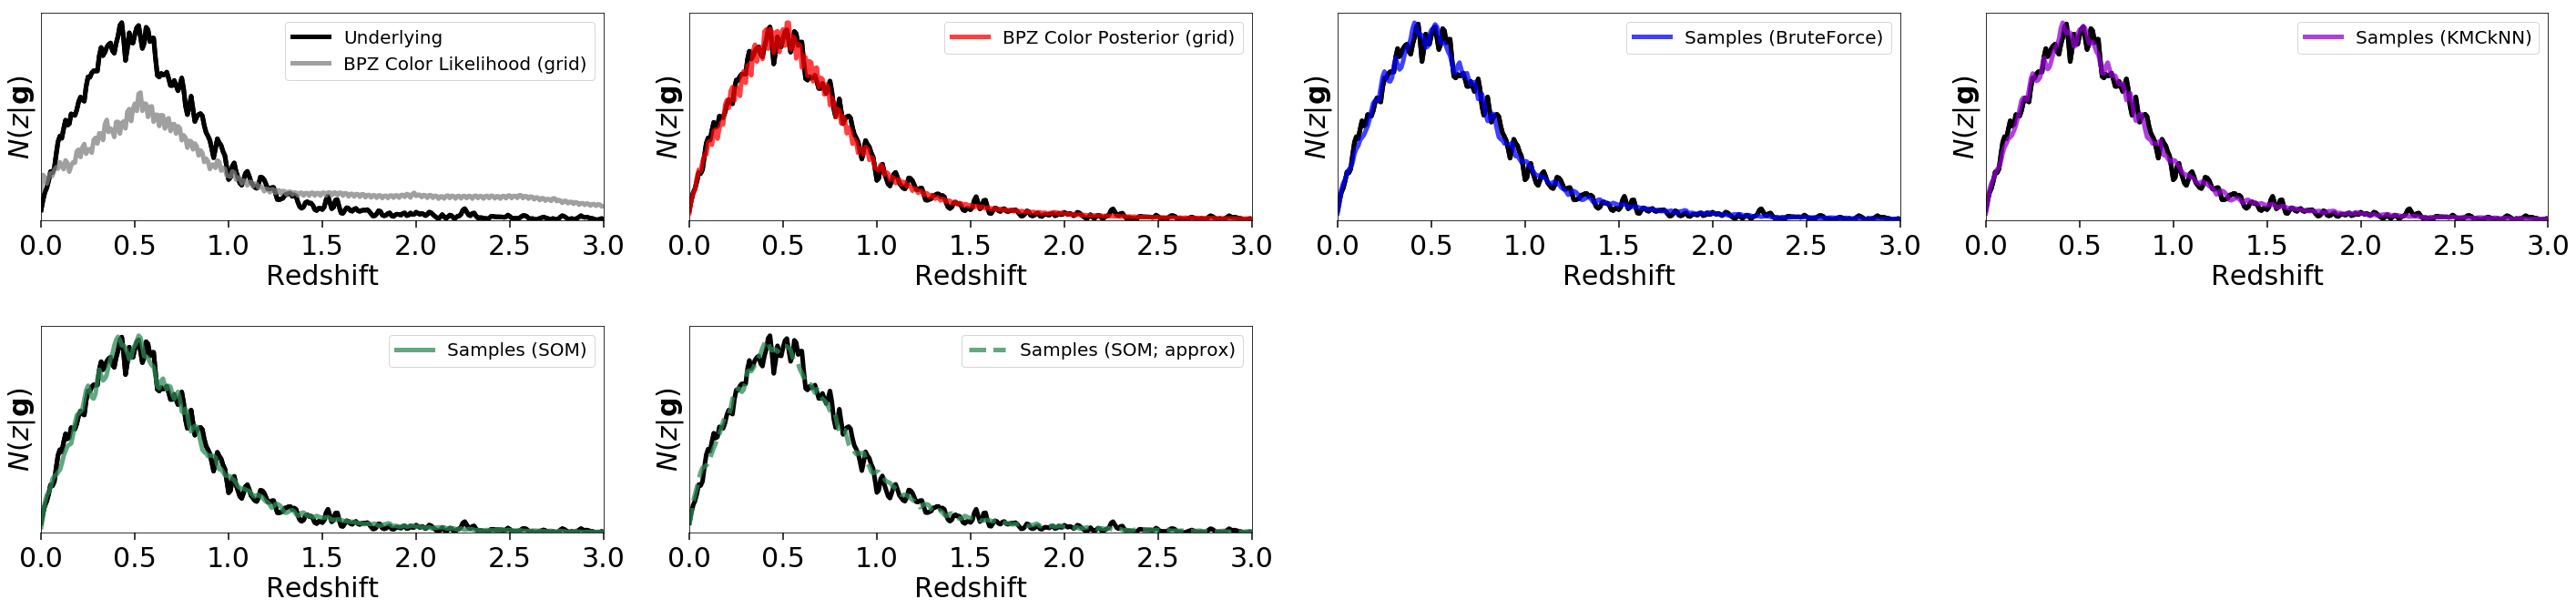

In [31]:
# plotting
plt.figure(figsize=(40, 10))
plt.subplot(2, 4, 1)
plt.plot(rdict.grid, zpdf0, lw=5, color='black',
         label='Underlying')
plt.plot(rdict.grid, pdfs_like.sum(axis=0), 
         lw=5, color='gray', alpha=0.75, 
         label='BPZ Color Likelihood (grid)')
for i in range(1, 5):
    plt.subplot(2, 4, i+1)
    plt.plot(rdict.grid, zpdf0, lw=5, color='black')
plt.subplot(2, 4, 2)
plt.plot(rdict.grid, pdfs_post.sum(axis=0), 
         lw=5, color='red', alpha=0.75,
         label='BPZ Color Posterior (grid)')
plt.subplot(2, 4, 3)
plt.plot(rdict.grid, pdfs_bf.sum(axis=0), 
         lw=5, color='blue', alpha=0.75,
         label='Samples (BruteForce)')
plt.subplot(2, 4, 4)
plt.plot(rdict.grid, pdfs_nn.sum(axis=0), 
         lw=5, color='darkviolet', alpha=0.75,
         label='Samples (KMCkNN)')
plt.subplot(2, 4, 5)
plt.plot(rdict.grid, pdfs_som.sum(axis=0), 
         lw=5, color='seagreen', alpha=0.75,
         label='Samples (SOM)')
plt.subplot(2, 4, 6)
plt.plot(rdict.grid, pdfs_som_approx.sum(axis=0), 
         lw=5, color='seagreen', alpha=0.75, ls='--',
         label='Samples (SOM; approx)')
for i in range(6):
    plt.subplot(2, 4, i+1)
    plt.plot(rdict.grid, zpdf0, lw=5, color='black', zorder=-1)
    plt.xlim([0., 3.])
    plt.ylim([0., None])
    plt.yticks([])
    plt.legend(fontsize=20)
    plt.xlabel('Redshift')
    plt.ylabel('$N(z|\mathbf{g})$')
    plt.tight_layout()

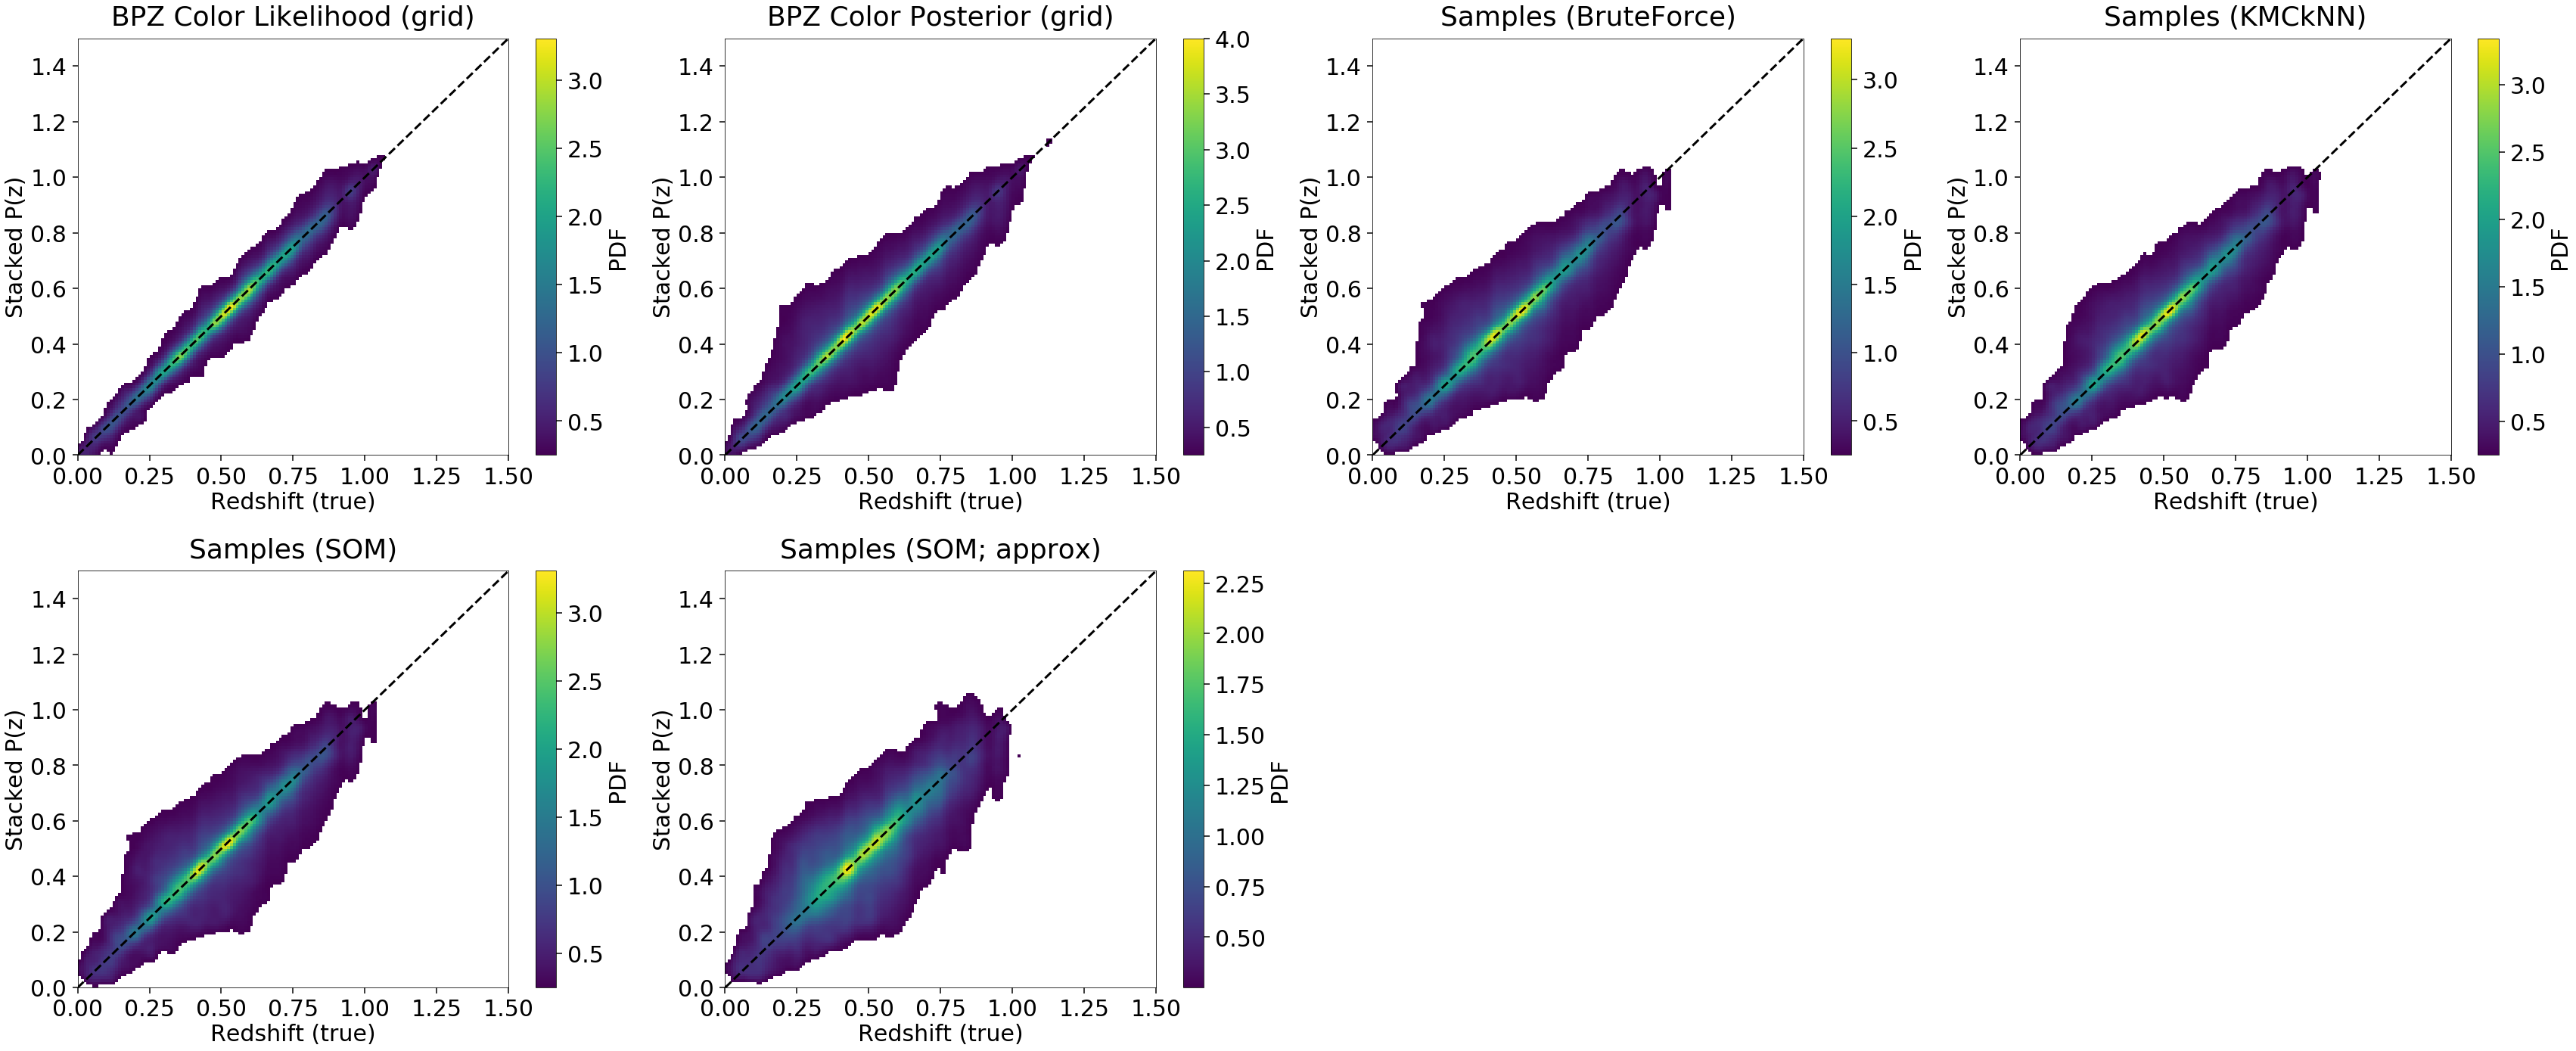

In [32]:
# plot stacked PDFs
plt.figure(figsize=(48, 20))
plt.subplot(2, 4, 1)
hh = fzplot.truth_vs_pdf(redshifts[test_sel], np.zeros_like(test_sel), 
                         pdfs_like, rdict, plot_thresh=0.25, smooth=1.5)
plt.title('BPZ Color Likelihood (grid)', y=1.02)
plt.subplot(2, 4, 2)
hh = fzplot.truth_vs_pdf(redshifts[test_sel], np.zeros_like(test_sel), 
                         pdfs_post, rdict, plot_thresh=0.25, smooth=1.5)
plt.title('BPZ Color Posterior (grid)', y=1.02)
plt.subplot(2, 4, 3)
hh = fzplot.truth_vs_pdf(redshifts[test_sel], np.zeros_like(test_sel), 
                         pdfs_bf, rdict, plot_thresh=0.25, smooth=1.5)
plt.title('Samples (BruteForce)', y=1.02)
plt.subplot(2, 4, 4)
hh = fzplot.truth_vs_pdf(redshifts[test_sel], np.zeros_like(test_sel), 
                         pdfs_nn, rdict, plot_thresh=0.25, smooth=1.5)
plt.title('Samples (KMCkNN)', y=1.02)
plt.subplot(2, 4, 5)
hh = fzplot.truth_vs_pdf(redshifts[test_sel], np.zeros_like(test_sel), 
                         pdfs_som, rdict, plot_thresh=0.25, smooth=1.5)
plt.title('Samples (SOM)', y=1.02)
plt.subplot(2, 4, 6)
hh = fzplot.truth_vs_pdf(redshifts[test_sel], np.zeros_like(test_sel), 
                         pdfs_som_approx, rdict, plot_thresh=0.25, smooth=1.5)
plt.title('Samples (SOM; approx)', y=1.02)
for i in range(6):
    plt.subplot(2, 4, i+1)
    plt.xlabel('Redshift (true)')
    plt.ylabel('Stacked P(z)')
    plt.xlim([0., 1.5])
    plt.ylim([0., 1.5])
    plt.tight_layout()

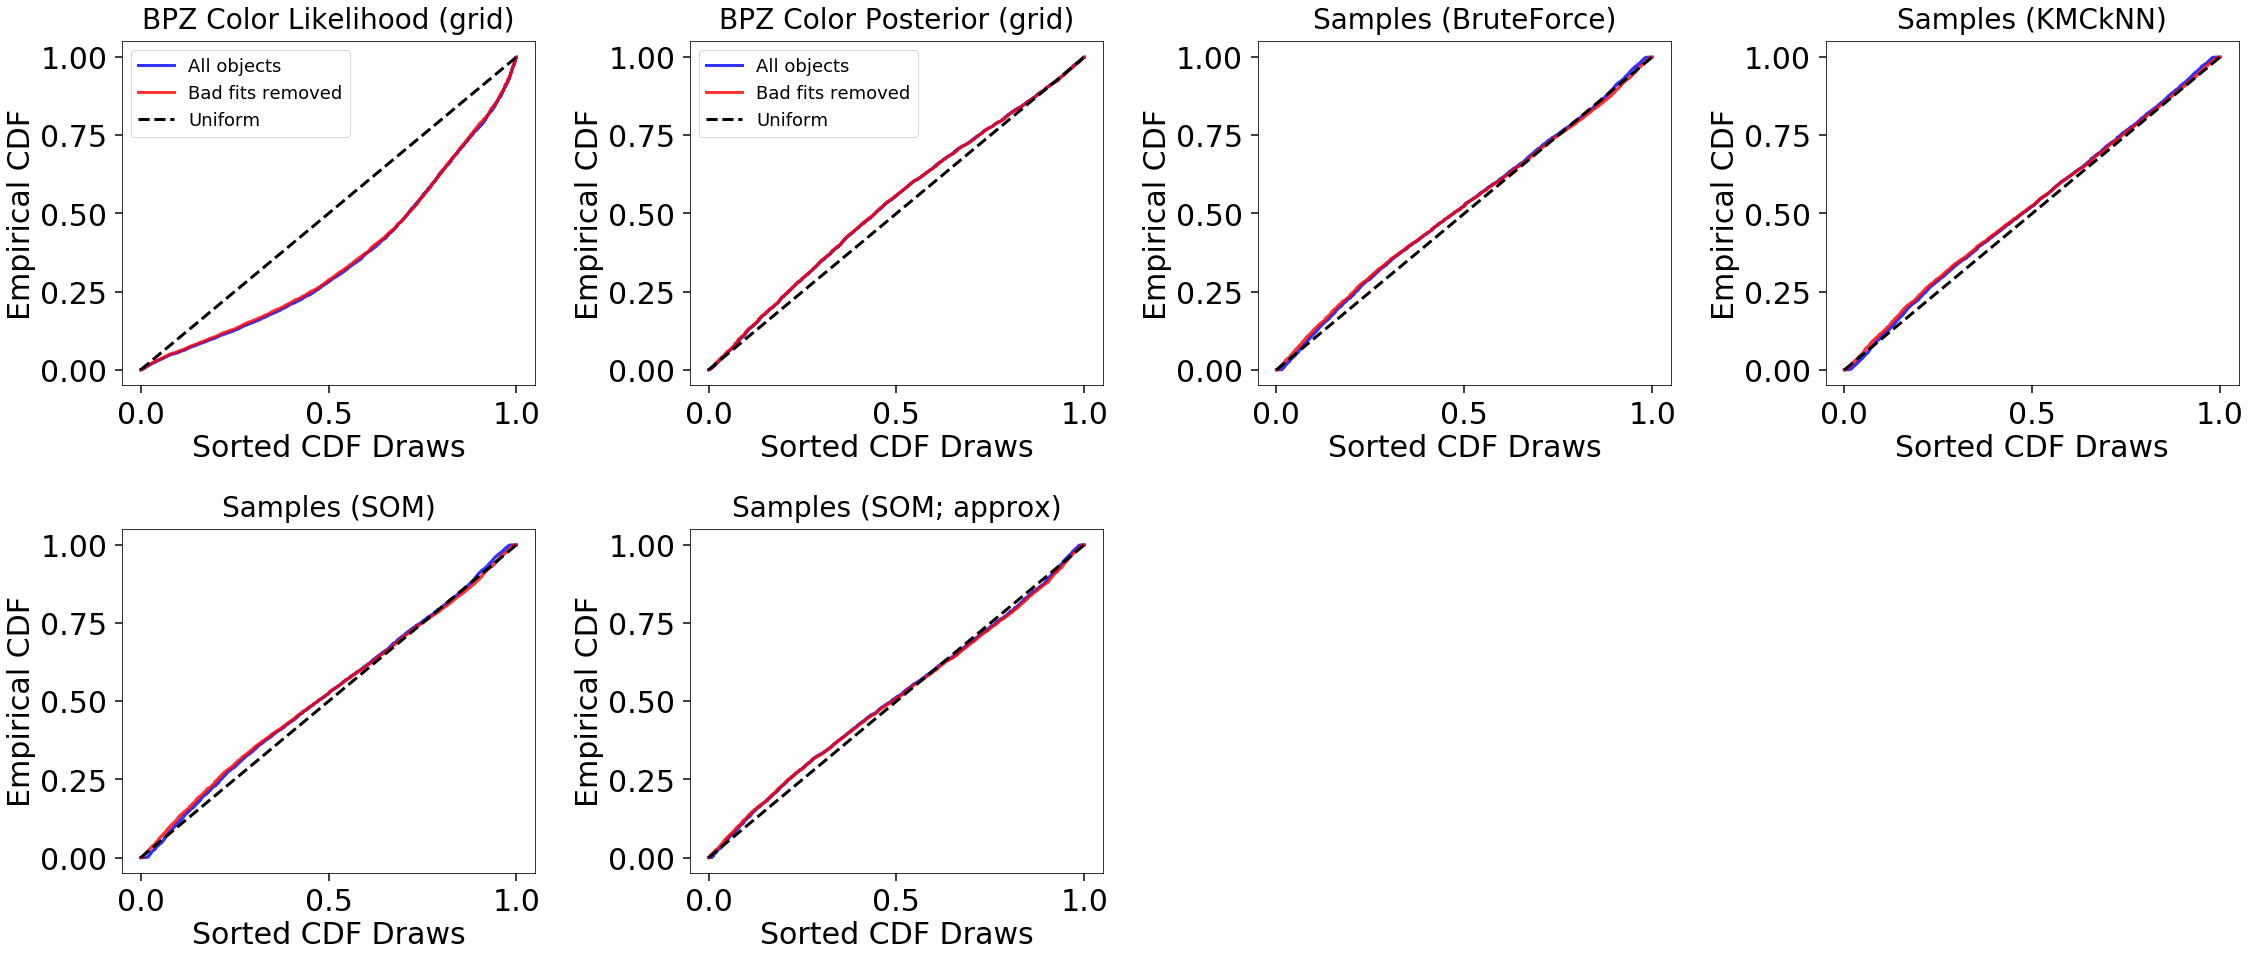

In [33]:
# plot CDF tests
plt.figure(figsize=(32, 14))
plt.subplot(2, 4, 1)
cdf_plot(pdfs_like, levid_like, lmap_like)
plt.legend(['All objects', 'Bad fits removed', 'Uniform'], loc='best', fontsize=18)
plt.title('BPZ Color Likelihood (grid)', fontsize=28, y=1.02)
plt.tight_layout()
plt.subplot(2, 4, 2)
cdf_plot(pdfs_post, levid_post, lmap_post)
plt.legend(['All objects', 'Bad fits removed', 'Uniform'], loc='best', fontsize=18)
plt.title('BPZ Color Posterior (grid)', fontsize=28, y=1.02)
plt.tight_layout()
plt.subplot(2, 4, 3)
cdf_plot(pdfs_bf, levid_bf, lmap_bf)
plt.title('Samples (BruteForce)', fontsize=28, y=1.02)
plt.tight_layout()
plt.subplot(2, 4, 4)
cdf_plot(pdfs_nn, levid_nn, lmap_nn)
plt.title('Samples (KMCkNN)', fontsize=28, y=1.02)
plt.tight_layout()
plt.subplot(2, 4, 5)
cdf_plot(pdfs_som, levid_som, lmap_som)
plt.title('Samples (SOM)', fontsize=28, y=1.02)
plt.tight_layout()
plt.subplot(2, 4, 6)
cdf_plot(pdfs_som_approx, levid_som_approx, lmap_som_approx)
plt.title('Samples (SOM; approx)', fontsize=28, y=1.02)
plt.tight_layout()

The results look very similar to those from our KMCkNN estimator for this sample, showing that our SOM-based approach appears to work well.

# Method 4: Growing Neural Gas (`GrowingNeuralGas`)

Two common issues that arise when training the SOM is that the topology (via the neighborhood function) and shape of the network must be specified ahead of time. While it is possible to use, e.g., the Bayesian evidence across the network to optimize the number of nodes (we will return to this later), ideally we would like to have a network that can both grow and adapt to local structure (and possible breakages) in the data.

This can be accomplished by trying to add structure to our network by transforming it into a **graph**, where **edges** between nodes define our topology (i.e. what constitutes a "neighbor" in our higher-dimensional space). `frankenz` implements one version of this type of algorithm known as a **Growing Neural Gas (GNG)**. The GNG does three things:
1. As training progresses, it adds nodes over time to try and better fit the data.
2. Based on the results of the training at a given iteration, it forms (and rejuvenates) connections between nodes to establish topology.
3. Over time, it also prunes old connections to keep the overall structure (relatively) sparse and ensure disconnected sub-networks can form.

While training a GNG is substantially more intensive than training a SOM, the resulting networks are often more efficiently allocated across the data space.

In [34]:
from frankenz.fitting import GrowingNeuralGas

train_GNG = GrowingNeuralGas(phot_train, err_train, mask_train)
train_GNG.train_network(err_kernel=0.02*phot_train)
train_GNG.populate_network()

Iteration 5000/5000 [nodes=2500, edges pruned=10] 
Mapping objects 100%


Note that, as with the SOM, it is difficult to train the GNG on photometric flux densities directly. We have just done so here for illustrative purposes.

In [35]:
pdfs_gng, gofs = train_GNG.fit_predict(phot_test, err_test, mask_test,
                                       redshifts[train_sel], 
                                       np.ones_like(train_sel) * rsmooth,
                                       lprob_func=lprob_train,
                                       label_dict=rdict, return_gof=True)
lmap_gng, levid_gng = gofs

Generating PDF 5000/5000


In [36]:
pdfs_gng_approx, gofs = train_GNG.fit_predict(phot_test, err_test, mask_test,
                                              redshifts[train_sel], 
                                              np.ones_like(train_sel) * rsmooth,
                                              nodes_only=True,
                                              lprob_func=lprob_train,
                                              label_dict=rdict, return_gof=True)
lmap_gng_approx, levid_gng_approx = gofs

Generating node PDF 2500/2500
Generating PDF 5000/5000


As before, let's see how both our approximations do.

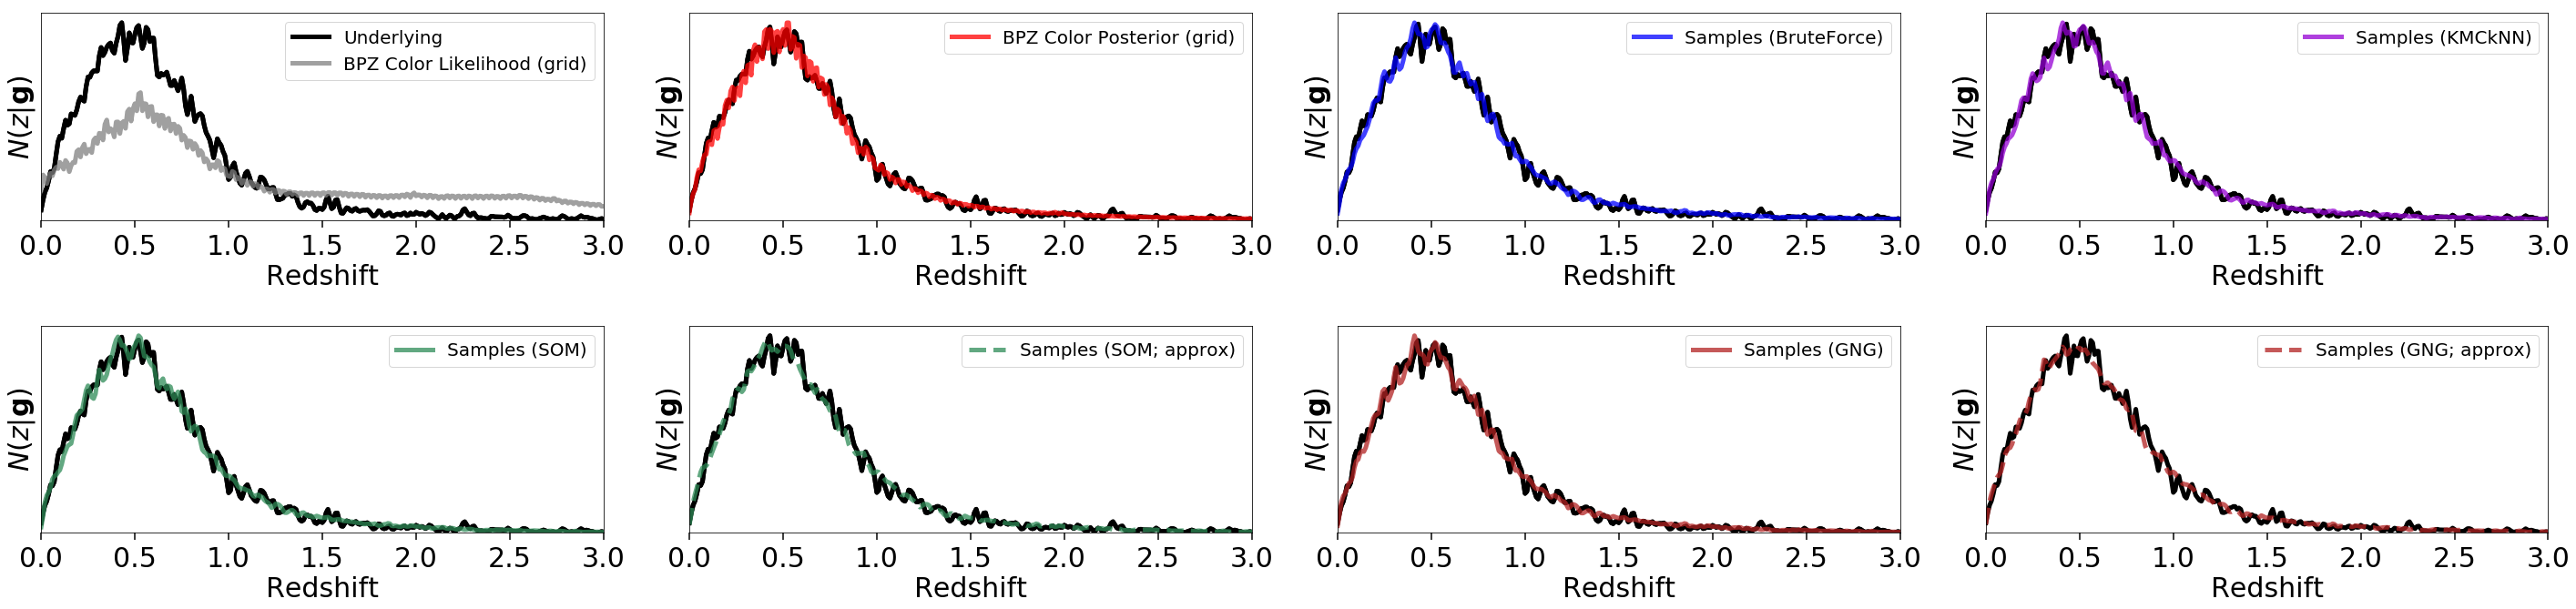

In [37]:
# plotting
plt.figure(figsize=(40, 10))
plt.subplot(2, 4, 1)
plt.plot(rdict.grid, zpdf0, lw=5, color='black',
         label='Underlying')
plt.plot(rdict.grid, pdfs_like.sum(axis=0), 
         lw=5, color='gray', alpha=0.75, 
         label='BPZ Color Likelihood (grid)')
for i in range(1, 7):
    plt.subplot(2, 4, i+1)
    plt.plot(rdict.grid, zpdf0, lw=5, color='black')
plt.subplot(2, 4, 2)
plt.plot(rdict.grid, pdfs_post.sum(axis=0), 
         lw=5, color='red', alpha=0.75,
         label='BPZ Color Posterior (grid)')
plt.subplot(2, 4, 3)
plt.plot(rdict.grid, pdfs_bf.sum(axis=0), 
         lw=5, color='blue', alpha=0.75,
         label='Samples (BruteForce)')
plt.subplot(2, 4, 4)
plt.plot(rdict.grid, pdfs_nn.sum(axis=0), 
         lw=5, color='darkviolet', alpha=0.75,
         label='Samples (KMCkNN)')
plt.subplot(2, 4, 5)
plt.plot(rdict.grid, pdfs_som.sum(axis=0), 
         lw=5, color='seagreen', alpha=0.75,
         label='Samples (SOM)')
plt.subplot(2, 4, 6)
plt.plot(rdict.grid, pdfs_som_approx.sum(axis=0), 
         lw=5, color='seagreen', alpha=0.75, ls='--',
         label='Samples (SOM; approx)')
plt.subplot(2, 4, 7)
plt.plot(rdict.grid, pdfs_gng.sum(axis=0), 
         lw=5, color='firebrick', alpha=0.75,
         label='Samples (GNG)')
plt.subplot(2, 4, 8)
plt.plot(rdict.grid, pdfs_gng_approx.sum(axis=0), 
         lw=5, color='firebrick', alpha=0.75, ls='--',
         label='Samples (GNG; approx)')
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.plot(rdict.grid, zpdf0, lw=5, color='black', zorder=-1)
    plt.xlim([0., 3.])
    plt.ylim([0., None])
    plt.yticks([])
    plt.legend(fontsize=20)
    plt.xlabel('Redshift')
    plt.ylabel('$N(z|\mathbf{g})$')
    plt.tight_layout()

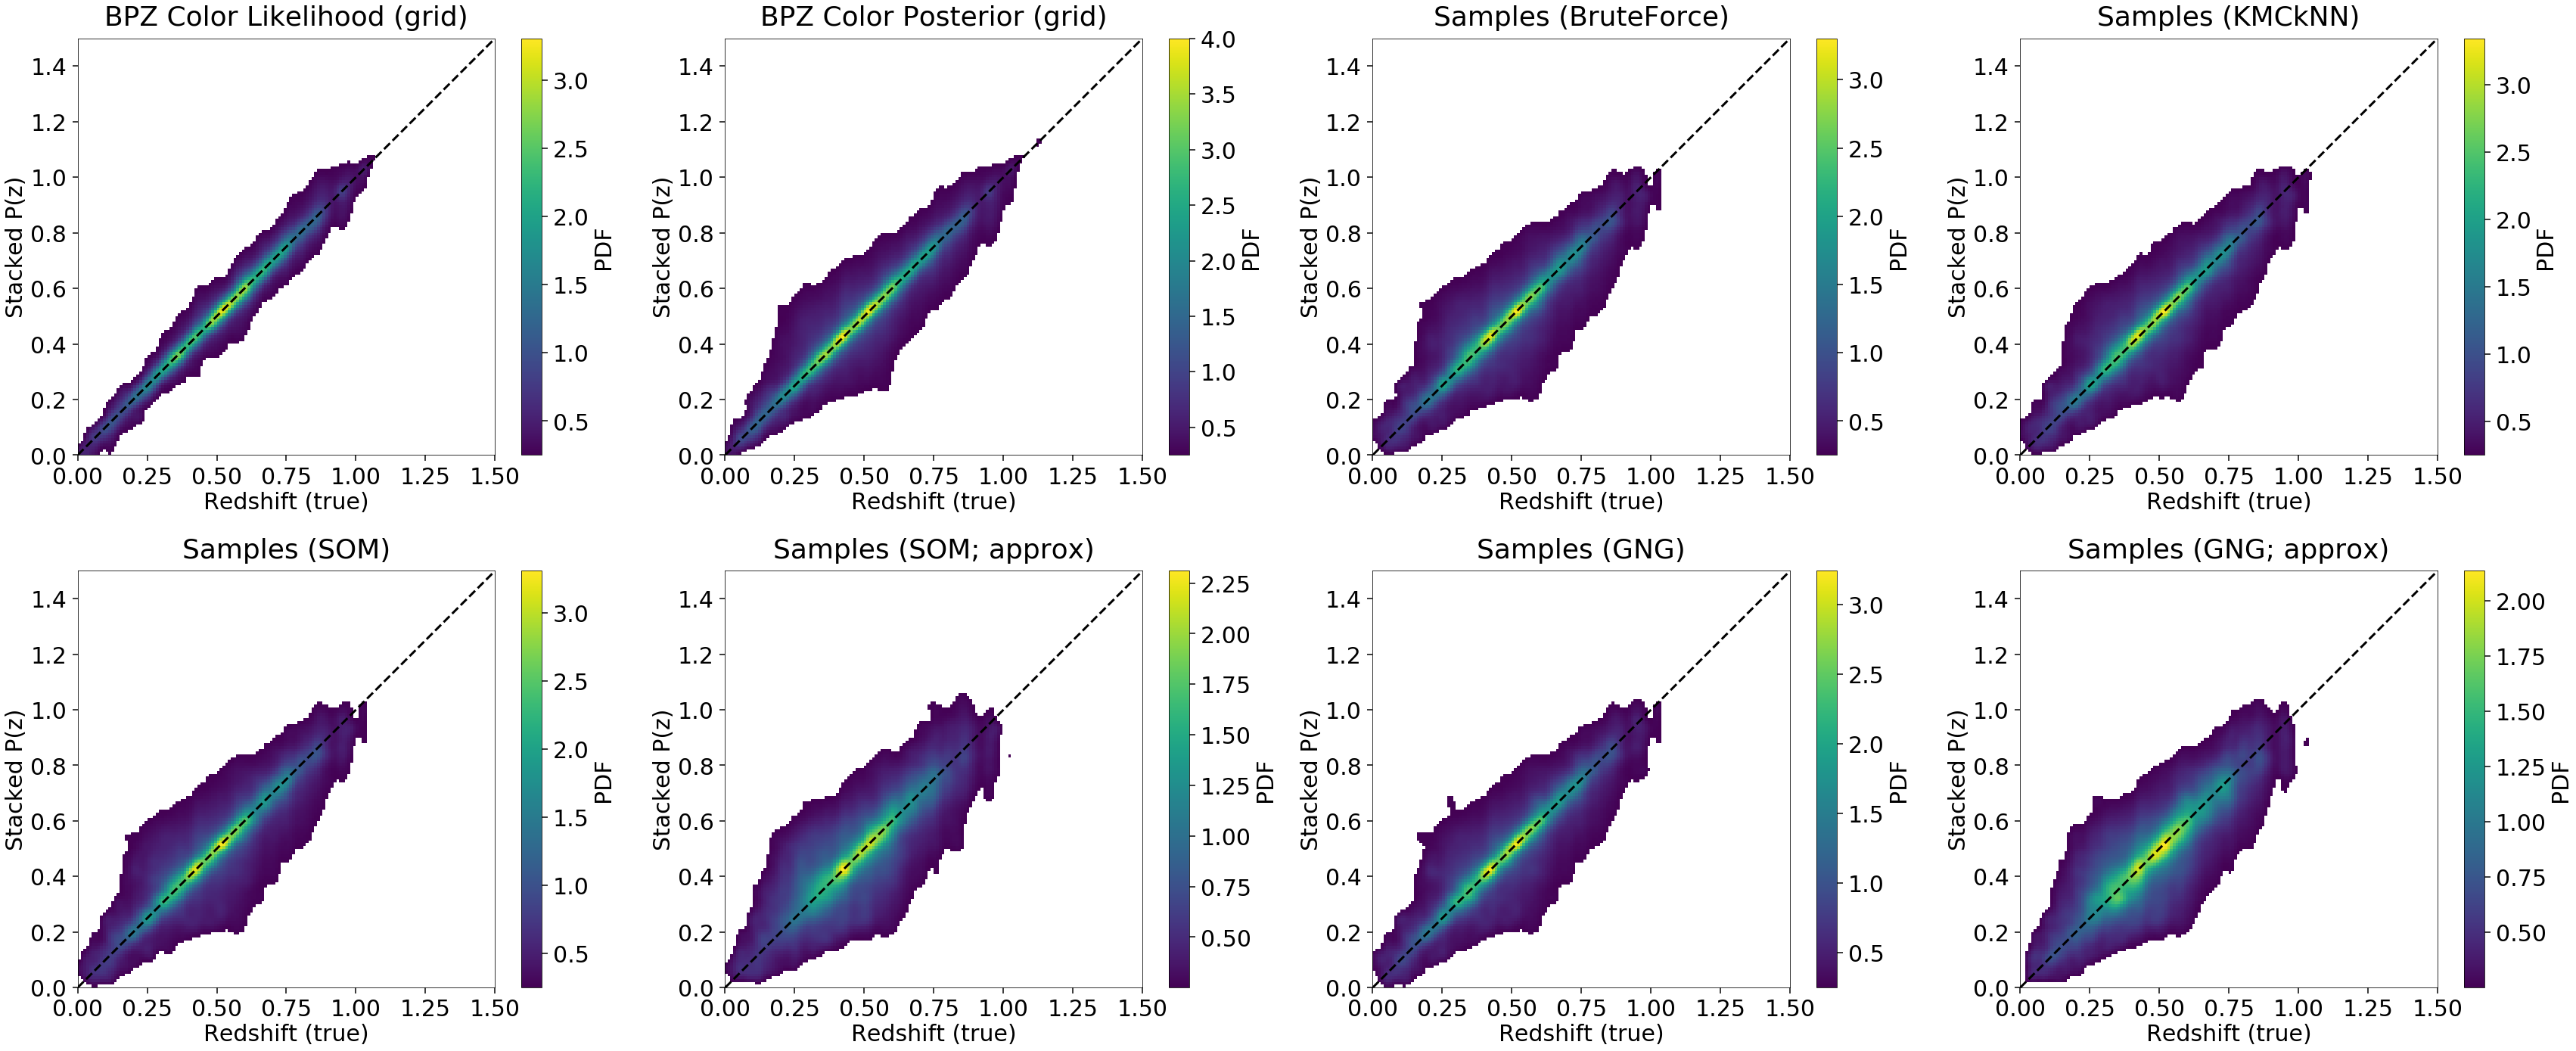

In [38]:
# plot stacked PDFs
plt.figure(figsize=(48, 20))
plt.subplot(2, 4, 1)
hh = fzplot.truth_vs_pdf(redshifts[test_sel], np.zeros_like(test_sel), 
                         pdfs_like, rdict, plot_thresh=0.25, smooth=1.5)
plt.title('BPZ Color Likelihood (grid)', y=1.02)
plt.subplot(2, 4, 2)
hh = fzplot.truth_vs_pdf(redshifts[test_sel], np.zeros_like(test_sel), 
                         pdfs_post, rdict, plot_thresh=0.25, smooth=1.5)
plt.title('BPZ Color Posterior (grid)', y=1.02)
plt.subplot(2, 4, 3)
hh = fzplot.truth_vs_pdf(redshifts[test_sel], np.zeros_like(test_sel), 
                         pdfs_bf, rdict, plot_thresh=0.25, smooth=1.5)
plt.title('Samples (BruteForce)', y=1.02)
plt.subplot(2, 4, 4)
hh = fzplot.truth_vs_pdf(redshifts[test_sel], np.zeros_like(test_sel), 
                         pdfs_nn, rdict, plot_thresh=0.25, smooth=1.5)
plt.title('Samples (KMCkNN)', y=1.02)
plt.subplot(2, 4, 5)
hh = fzplot.truth_vs_pdf(redshifts[test_sel], np.zeros_like(test_sel), 
                         pdfs_som, rdict, plot_thresh=0.25, smooth=1.5)
plt.title('Samples (SOM)', y=1.02)
plt.subplot(2, 4, 6)
hh = fzplot.truth_vs_pdf(redshifts[test_sel], np.zeros_like(test_sel), 
                         pdfs_som_approx, rdict, plot_thresh=0.25, smooth=1.5)
plt.title('Samples (SOM; approx)', y=1.02)
plt.subplot(2, 4, 7)
hh = fzplot.truth_vs_pdf(redshifts[test_sel], np.zeros_like(test_sel), 
                         pdfs_gng, rdict, plot_thresh=0.25, smooth=1.5)
plt.title('Samples (GNG)', y=1.02)
plt.subplot(2, 4, 8)
hh = fzplot.truth_vs_pdf(redshifts[test_sel], np.zeros_like(test_sel), 
                         pdfs_gng_approx, rdict, plot_thresh=0.25, smooth=1.5)
plt.title('Samples (GNG; approx)', y=1.02)
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.xlabel('Redshift (true)')
    plt.ylabel('Stacked P(z)')
    plt.xlim([0., 1.5])
    plt.ylim([0., 1.5])
    plt.tight_layout()

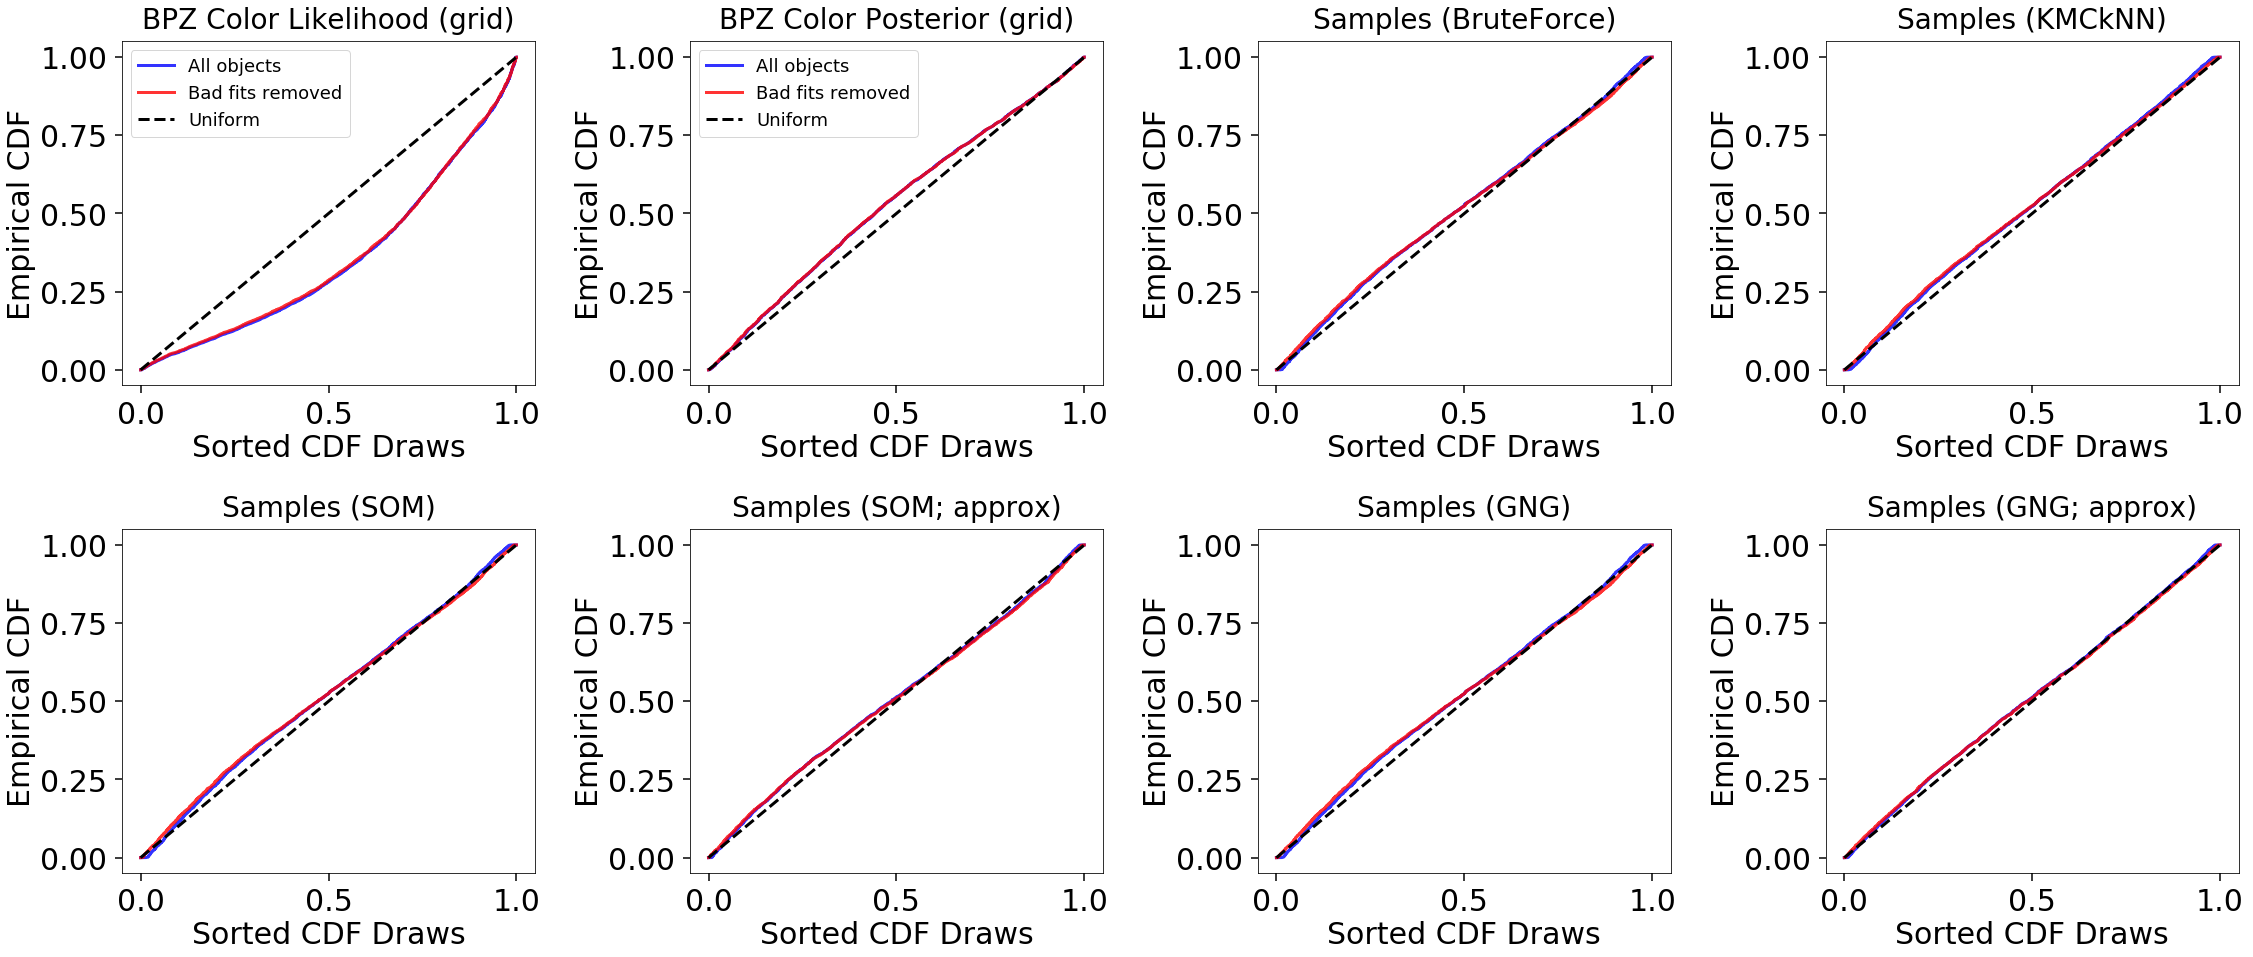

In [39]:
# plot CDF tests
plt.figure(figsize=(32, 14))
plt.subplot(2, 4, 1)
cdf_plot(pdfs_like, levid_like, lmap_like)
plt.legend(['All objects', 'Bad fits removed', 'Uniform'], loc='best', fontsize=18)
plt.title('BPZ Color Likelihood (grid)', fontsize=28, y=1.02)
plt.tight_layout()
plt.subplot(2, 4, 2)
cdf_plot(pdfs_post, levid_post, lmap_post)
plt.legend(['All objects', 'Bad fits removed', 'Uniform'], loc='best', fontsize=18)
plt.title('BPZ Color Posterior (grid)', fontsize=28, y=1.02)
plt.tight_layout()
plt.subplot(2, 4, 3)
cdf_plot(pdfs_bf, levid_bf, lmap_bf)
plt.title('Samples (BruteForce)', fontsize=28, y=1.02)
plt.tight_layout()
plt.subplot(2, 4, 4)
cdf_plot(pdfs_nn, levid_nn, lmap_nn)
plt.title('Samples (KMCkNN)', fontsize=28, y=1.02)
plt.tight_layout()
plt.subplot(2, 4, 5)
cdf_plot(pdfs_som, levid_som, lmap_som)
plt.title('Samples (SOM)', fontsize=28, y=1.02)
plt.tight_layout()
plt.subplot(2, 4, 6)
cdf_plot(pdfs_som_approx, levid_som_approx, lmap_som_approx)
plt.title('Samples (SOM; approx)', fontsize=28, y=1.02)
plt.tight_layout()
plt.subplot(2, 4, 7)
cdf_plot(pdfs_gng, levid_gng, lmap_gng)
plt.title('Samples (GNG)', fontsize=28, y=1.02)
plt.tight_layout()
plt.subplot(2, 4, 8)
cdf_plot(pdfs_gng_approx, levid_gng_approx, lmap_gng_approx)
plt.title('Samples (GNG; approx)', fontsize=28, y=1.02)
plt.tight_layout()

The results look very similar to those from our SOM-based estimator for this sample.